### Importing Libaries

In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install -q tokenizers
!pip install -q torch
!pip install -q sacrebleu
!pip install -q rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [ ]:
## mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## New chunking strategy + instruction prompt for flan5 base

In [ ]:
import json
import multiprocessing
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
MAX_TOKENS = 512
OVERLAP = 256

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
def check_impossible_distribution(dataset):
    """
    Analyzes the distribution of answers in the dataset based on the 'is_impossible' field.

    Args:
        dataset (list): List of contracts, each containing paragraphs and QA pairs.

    Returns:
        dict: Distribution statistics of impossible vs. non-impossible answers.
    """
    total_count = 0
    impossible_count = 0
    possible_count = 0

    for contract in dataset:
        for paragraph in contract["paragraphs"]:
            for qa in paragraph["qas"]:
                total_count += 1
                if qa.get("is_impossible", False):  # Check for impossible answers
                    impossible_count += 1
                else:
                    possible_count += 1

    # Calculate percentages
    impossible_percentage = (impossible_count / total_count) * 100 if total_count > 0 else 0
    possible_percentage = (possible_count / total_count) * 100 if total_count > 0 else 0

    print(f"Total QA Pairs: {total_count}")
    print(f"Impossible (no answer): {impossible_count} ({impossible_percentage:.2f}%)")
    print(f"Possible (with answer): {possible_count} ({possible_percentage:.2f}%)")

    # Return distribution stats as a dictionary
    return {
        "total_count": total_count,
        "impossible_count": impossible_count,
        "possible_count": possible_count,
        "impossible_percentage": impossible_percentage,
        "possible_percentage": possible_percentage
    }

#  Load the CUAD dataset
with open('/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/CUAD_v1.json', 'r', encoding='utf-8') as file:
    raw_data = json.load(file)["data"]

# Check the distribution of answers
distribution_stats = check_impossible_distribution(raw_data)


Total QA Pairs: 20910
Impossible (no answer): 14208 (67.95%)
Possible (with answer): 6702 (32.05%)


In [ ]:
# Chunking Function
def split_text_into_chunks(text, max_tokens, tokenizer, prompt_length, overlap=256):
    """
    Splits text into overlapping chunks while maintaining clause integrity.
    Uses a sliding window approach with a specified overlap size.
    """
    # Adjust the max_tokens to account for the prompt length
    max_tokens -= prompt_length
    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        # Form a chunk from the current window
        chunk_words = words[start:start + max_tokens]
        chunk_text = " ".join(chunk_words)

        # Tokenize and ensure chunk length is within limits
        tokenized = tokenizer(chunk_text, add_special_tokens=False, truncation=True, max_length=max_tokens)
        tokenized_chunk = tokenized["input_ids"]
        truncated_text = tokenizer.decode(tokenized_chunk, skip_special_tokens=True)

        # Try to end the chunk at a sentence boundary if possible
        if len(truncated_text) < max_tokens and "." in truncated_text:
            end = truncated_text.rfind(".") + 1
            if end > 0:
                truncated_text = truncated_text[:end]

        chunks.append(truncated_text)
        # Move the start pointer forward by max_tokens minus overlap (sliding window)
        start += max_tokens - overlap

    return chunks

#last chunk
def restructure_dataset_for_qa(contract, doc_id, tokenizer, max_tokens=512, overlap=256):
    """
    Restructures a contract into question-chunk pairs using a sliding window and includes metadata.
    Filters out QA pairs where the answer is not present.
    """
    contract_title = contract["title"]
    paragraphs = contract["paragraphs"]
    processed_data = []

    # Combine all paragraph texts into a single cleaned context
    full_text = " ".join([para["context"] for para in paragraphs])

    for paragraph in paragraphs:
        for qa in paragraph["qas"]:
            if qa["is_impossible"]:
                continue
            clause_type = qa["question"].split("related to \"")[1].split("\"")[0] if "related to \"" in qa["question"] else "General"
            question_text = qa["question"]
            if "Details:" in question_text:
                question_text = question_text.split("Details:")[0].strip()
            expected_answers = [ans["text"] for ans in qa["answers"]]

            # Create the input prompt
            input_prompt = (
                f"You are a legal document analyst specializing in contract clause identification. "
                f"Your task is to accurately extract the {clause_type} from the provided text. "
                f"1. Only extract the exact clause without adding or removing words.\n"
                f"QUESTION: {question_text}\n"
                f"CONTEXT: "
            ) #f"2. If the {clause_type} is missing or not explicitly present, return 'No Answer'.\n"

            # Get the length of the prompt in tokens
            prompt_length = len(tokenizer.encode(input_prompt, add_special_tokens=False))

            # Generate chunks with the adjusted max length
            chunks = split_text_into_chunks(full_text, max_tokens, tokenizer, prompt_length, overlap)

            # Iterate through each chunk to pair it with the question and metadata
            for chunk in chunks:
                answer_presence = any(answer in chunk for answer in expected_answers)
                flag = "answer_present" if answer_presence else "answer_not_present"
                input_text = input_prompt + chunk

                processed_data.append({
                    "doc_id": doc_id,
                    "contract_title": contract_title,
                    "clause_type": clause_type,
                    "question": question_text,
                    "input": input_text ,
                    "expected_output": expected_answers if answer_presence else ["No answer"],
                    "flag": flag
                })

    return processed_data

# Processing All Contracts
def process_all_contracts(dataset, tokenizer):
    """
    Apply chunking and restructuring to all contracts in the dataset.
    """
    data_with_ids = [(contract, idx) for idx, contract in enumerate(dataset)]

    with multiprocessing.Pool(processes=8) as pool:
        # Use restructure_dataset_for_qa directly instead of a lambda
        chunked_results = pool.starmap(
            restructure_dataset_for_qa,  # Pass the function directly
            [(contract, doc_id, tokenizer) for contract, doc_id in data_with_ids]
        )

    # Flatten the list of results
    restructured_dataset = [sample for sublist in chunked_results for sample in sublist]
    return restructured_dataset

# Load the CUAD dataset
with open('/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/CUAD_v1.json', 'r', encoding='utf-8') as file:
    raw_data = json.load(file)["data"]

# Apply chunking and restructuring
chunked_dataset = process_all_contracts(raw_data, tokenizer)

In [ ]:
chunked_dataset[19]

{'doc_id': 0,
 'contract_title': 'LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT',
 'clause_type': 'Document Name',
 'question': 'Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer.',
 'input': 'You are a legal document analyst specializing in contract clause identification. Your task is to accurately extract the Document Name from the provided text. 1. Only extract the exact clause without adding or removing words.\nQUESTION: Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer.\nCONTEXT: owned by the other party. The Distributor shall not disclose this agreement except upon consent of Company. Confidential information shall not include information which: (A) Is or becomes generally available to the party who desires to disclose such information (or its associated or affiliated companies) (a "Disclosing Party") other than as a result of a breach of this Agreement or s

In [ ]:
# Display sample data
print("Number of samples:", len(chunked_dataset))

Number of samples: 398660


### Dataset exploration after chunking: Exploring and correcting imbalance
- why are we correcting imbalance?
- what happened in the other experiments with imbalanced data? train loss of 0 and nan loss.
- techniques did i try? weighting samples etc
- new strategy: randomly drop 60% of 'no answer' chunks to keep a high focus on chunks with answers.


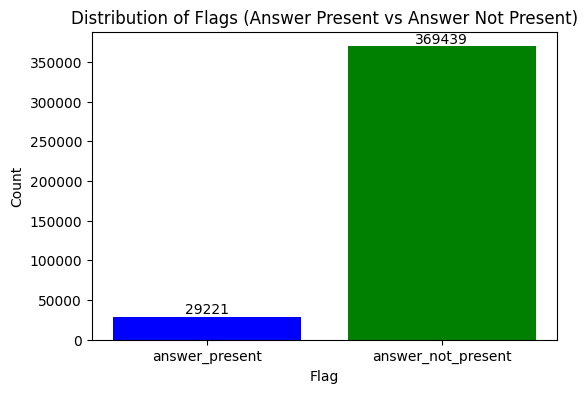

In [ ]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Extract the flag values from the dataset
flags = [item['flag'] for item in chunked_dataset]

# Count occurrences of each flag
flag_counts = Counter(flags)

# Plotting the distribution
plt.figure(figsize=(6, 4))
bars = plt.bar(flag_counts.keys(), flag_counts.values(), color=['blue', 'green'])

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, int(yval), ha='center', va='bottom')

plt.title("Distribution of Flags (Answer Present vs Answer Not Present)")
plt.xlabel("Flag")
plt.ylabel("Count")
plt.show()


In [ ]:
#saving chunked_no_answer dataset
with open("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/CUAD_no_answer_chunked.json", "w", encoding="utf-8") as f:
    json.dump(chunked_dataset, f, ensure_ascii=False, indent=4)
print("Formatted dataset with metadata saved as 'example5_chunked")

Formatted dataset with metadata saved as 'example5_chunked


### Downsample empty chunks to 40% of the dataset

In [ ]:
import random

def undersample_no_answer_chunks(dataset, no_answer_label="no answer", target_ratio=0.40, seed=42):
    """
    Returns a filtered version of the dataset where 'no answer' chunks are undersampled
    to the desired ratio relative to the total dataset size.

    Args:
        dataset: list of dicts (chunked_dataset)
        no_answer_label (str): the consistent label used for 'no answer' chunks
        target_ratio (float): the proportion of 'no answer' chunks in the final dataset
        seed (int): for reproducible random sampling

    Returns:
        list of filtered dicts
    """
    random.seed(seed)

    # Separate chunks
    no_answer_chunks = [chunk for chunk in dataset if chunk['flag'] == "answer_not_present"]
    answer_chunks = [chunk for chunk in dataset if chunk['flag'] == "answer_present"]

    # Calculate how many 'no answer' chunks to retain
    target_no_answer_count = int((len(answer_chunks) / (1 - target_ratio)) * target_ratio)

    # Randomly sample 'no answer' chunks
    sampled_no_answer_chunks = random.sample(no_answer_chunks, min(target_no_answer_count, len(no_answer_chunks)))

    # Combine and shuffle
    final_dataset = answer_chunks + sampled_no_answer_chunks
    random.shuffle(final_dataset)

    return final_dataset
chunked_dataset1 = undersample_no_answer_chunks(chunked_dataset)
print(f"Filtered dataset size: {len(chunked_dataset1)}")


Filtered dataset size: 48701


### Save datasets

In [ ]:
#save formatted dataset
with open("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/CUAD_no_answer_filtered_chunked.json", "w", encoding="utf-8") as f:
    json.dump(chunked_dataset1, f, ensure_ascii=False, indent=4)
print("Filtered chunked dataset with metadata saved.")

Filtered chunked dataset with metadata saved.


### new dataset size after down sampling no answer chunks

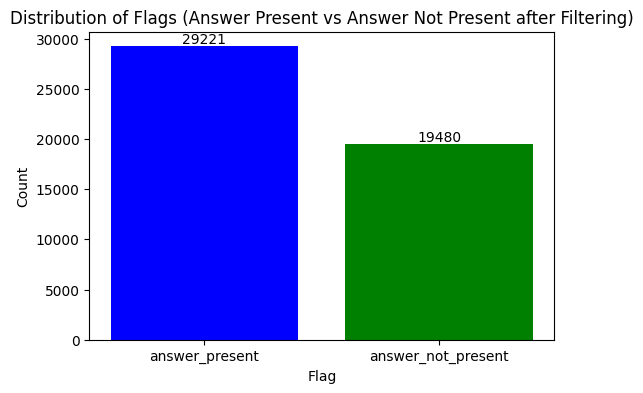

In [ ]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Extract the flag values from the dataset
flags = [item['flag'] for item in chunked_dataset1]

# Count occurrences of each flag
flag_counts = Counter(flags)

# Plotting the distribution
plt.figure(figsize=(6, 4))
bars = plt.bar(flag_counts.keys(), flag_counts.values(), color=['blue', 'green'])

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, int(yval), ha='center', va='bottom')

plt.title("Distribution of Flags (Answer Present vs Answer Not Present after Filtering)")
plt.xlabel("Flag")
plt.ylabel("Count")
plt.show()


---
### reload dataset

In [ ]:
#reload chunked dataset from
import json
with open("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/Data/CUAD_no_answer_filtered_chunked.json", "r") as f:
    chunked_dataset = json.load(f)

In [ ]:
import random

def undersample_no_answer_chunks(dataset, no_answer_label="no answer", target_ratio=0.40, seed=42):
    """
    Returns a filtered version of the dataset where 'no answer' chunks are undersampled
    to the desired ratio relative to the total dataset size.

    Args:
        dataset: list of dicts (chunked_dataset)
        no_answer_label (str): the consistent label used for 'no answer' chunks
        target_ratio (float): the proportion of 'no answer' chunks in the final dataset
        seed (int): for reproducible random sampling

    Returns:
        list of filtered dicts
    """
    random.seed(seed)

    # Separate chunks
    no_answer_chunks = [chunk for chunk in dataset if chunk['flag'] == "answer_not_present"]
    answer_chunks = [chunk for chunk in dataset if chunk['flag'] == "answer_present"]

    # Calculate how many 'no answer' chunks to retain
    target_no_answer_count = int((len(answer_chunks) / (1 - target_ratio)) * target_ratio)

    # Randomly sample 'no answer' chunks
    sampled_no_answer_chunks = random.sample(no_answer_chunks, min(target_no_answer_count, len(no_answer_chunks)))

    # Combine and shuffle
    final_dataset = answer_chunks + sampled_no_answer_chunks
    random.shuffle(final_dataset)

    return final_dataset
chunked_dataset1 = undersample_no_answer_chunks(chunked_dataset)
print(f"Filtered dataset size: {len(chunked_dataset1)}")


Filtered dataset size: 48701


### converting final dataset to Hf format
first convert final dataset to hugging face model
and ensure all chunks are equally distributed

In [ ]:
import datasets
from datasets import Dataset, DatasetDict

# Convert to Hugging Face Dataset format
hf_dataset = Dataset.from_list(chunked_dataset)

# Split into train (80%), validation (10%), and test (10%)
train_test_split = hf_dataset.train_test_split(test_size=0.2, seed=42)
valid_test_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

# Correctly label the dataset splits
dataset = DatasetDict({
    "train": train_test_split["train"],
    "validation": valid_test_split["train"],  # Corrected label
    "test": valid_test_split["test"]  # Corrected label
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag'],
        num_rows: 38960
    })
    validation: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag'],
        num_rows: 4870
    })
    test: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag'],
        num_rows: 4871
    })
})

In [ ]:
from collections import Counter

def print_answer_ratios(dataset_dict, flag_field="flag", no_answer_value="answer_not_present"):
    for split in dataset_dict:
        split_data = dataset_dict[split]
        flags = split_data[flag_field]
        counts = Counter(flags)

        total = sum(counts.values())
        no_answer = counts.get(no_answer_value, 0)
        answer = total - no_answer
        ratio = answer / total if total else 0

        print(f"\n {split.upper()} SPLIT")
        print(f"Answer present     : {answer}")
        print(f"Answer not present : {no_answer}")
        print(f"Answer ratio       : {ratio:.2%}")

# Example usage
print_answer_ratios(dataset)



 TRAIN SPLIT
Answer present     : 23360
Answer not present : 15600
Answer ratio       : 59.96%

 VALIDATION SPLIT
Answer present     : 2887
Answer not present : 1983
Answer ratio       : 59.28%

 TEST SPLIT
Answer present     : 2974
Answer not present : 1897
Answer ratio       : 61.06%


Goal: Balance Answered and Unanswered Examples
For each split (train, validation, test), ensure a 60-40 ish balance between:

- Answer examples → flag != 'answer_not_present'

- No-answer examples → flag == 'answer_not_present

### tokenizing

In [ ]:
MAX_SEQUENCE_LENGTH = 512

def tokenize_function(examples):
    """
    Tokenizes the input and output texts for Flan-T5.
    """
    # Extract input and output directly from the batch dictionary
    inputs = examples['input']
    outputs = [ex[0] if ex else "" for ex in examples['expected_output']]

    # Tokenize the inputs (questions + context + flag) in batch mode
    encoded_inputs = tokenizer(
        inputs,
        max_length=MAX_SEQUENCE_LENGTH,
        padding='max_length',
        truncation=True
    )

    # Tokenize the outputs (expected answers or placeholders) in batch mode
    encoded_outputs = tokenizer(
        outputs,
        max_length=MAX_SEQUENCE_LENGTH,
        padding='max_length',
        truncation=True
    )

    # Replace padding token ID (0) with -100 for labels
    labels = encoded_outputs['input_ids']
    labels = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in labels]

    return {
        'input_ids': encoded_inputs['input_ids'],
        'attention_mask': encoded_inputs['attention_mask'],
        'labels': labels
    }

# Apply tokenization separately to each split
tokenized_datasets = {
    split: dataset[split].map(
        tokenize_function,
        batched=True, #remove_columns=['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag']
    )
    for split in ['train', 'validation','test']
}

print(tokenized_datasets)


Map:   0%|          | 0/38960 [00:00<?, ? examples/s]

Map:   0%|          | 0/4870 [00:00<?, ? examples/s]

Map:   0%|          | 0/4871 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 38960
}), 'validation': Dataset({
    features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 4870
}), 'test': Dataset({
    features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 4871
})}


preview of tokenized dataset

In [ ]:
for i in range(3):  # Checking 3 examples
    print(f"Example {i+1}:")
    print("Input IDs:", tokenized_datasets["train"][i]["input_ids"])
    print("Labels:", tokenized_datasets["train"][i]["labels"])
    print("="*80)

Example 1:
Input IDs: [148, 33, 3, 9, 1281, 1708, 15649, 3, 7, 26253, 16, 1696, 14442, 10356, 5, 696, 2491, 19, 12, 12700, 5819, 8, 22619, 2570, 1538, 297, 45, 8, 937, 1499, 5, 1300, 3462, 5819, 8, 2883, 14442, 406, 2651, 42, 3, 8499, 1234, 5, 3, 15367, 134, 9562, 10, 16388, 8, 1467, 41, 99, 136, 61, 13, 48, 1696, 1341, 12, 96, 12858, 603, 440, 2570, 1538, 297, 121, 24, 225, 36, 9112, 57, 3, 9, 6297, 5, 8472, 3463, 4, 382, 10, 3, 226, 3, 10124, 15386, 11, 460, 439, 115, 16, 812, 5, 37, 738, 13, 8, 16290, 1522, 36, 8794, 57, 11481, 11, 1522, 4535, 28, 4360, 2268, 11, 738, 10364, 8794, 57, 5220, 5787, 287, 5, 1682, 26789, 2865, 5, 5220, 5787, 287, 2065, 7, 12, 2156, 3, 9, 7206, 2559, 13, 220, 23916, 26789, 2865, 399, 847, 21, 8, 1657, 13, 48, 7139, 5, 389, 96, 196, 51, 8243, 121, 19, 4802, 38, 8, 1831, 13, 8, 11481, 16290, 12, 3, 9, 1139, 30, 80, 13, 8, 756, 2848, 26, 1688, 5, 1877, 19254, 8495, 7, 5, 11481, 2065, 7, 12, 726, 5220, 5787, 287, 6, 383, 8, 1657, 13, 48, 7139, 6, 38, 6963, 1

saving tokenized dataset

In [ ]:
from datasets import DatasetDict

# Convert the dictionary of Datasets back to a DatasetDict object
tokenized_datasets = DatasetDict(tokenized_datasets)

# Save to directory format (not a single file)
tokenized_datasets.save_to_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/tokenized_datasets/CUAD_filtered_tokenized") #the ending in CUAD_chunked_no_answer_tokenized40 includes only 3 columns

Saving the dataset (0/1 shards):   0%|          | 0/38960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4870 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4871 [00:00<?, ? examples/s]

reloading tokenized dataset

In [ ]:
#load tokenized
from datasets import load_from_disk

tokenized_datasets = load_from_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/tokenized_datasets/CUAD_filtered_tokenized")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 38960
    })
    validation: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4870
    })
    test: Dataset({
        features: ['doc_id', 'contract_title', 'clause_type', 'question', 'input', 'expected_output', 'flag', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4871
    })
})

In [ ]:
#save tokenized dataset

## Training Flan5 with instruction prompt

In [ ]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer
from datasets import DatasetDict

#  Helps avoid OOM errors on some GPUs
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Device setup
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

# Model and Tokenizer Loading
def load_model_and_tokenizer(model_name="google/flan-t5-base"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(get_device())
    return model, tokenizer

In [ ]:
def create_training_args():
    return TrainingArguments(
        output_dir="./flan_t5_legal",
        eval_strategy="epoch",
        #Add save strategy
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=3e-5,
        weight_decay=0.01,
        num_train_epochs=5,
        max_grad_norm=1.0,
        warmup_steps=500,
        gradient_accumulation_steps=2,
        logging_dir="./logs",
        logging_steps=10,
        report_to="none",
        fp16=False,
        label_smoothing_factor=0.1
    )

# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer()

# Load training arguments
training_args = create_training_args()

# Define collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:

# Setup trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train
trainer.train()


<ipython-input-4-f8e9ce18e4e3>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,2.265200,2.139351
2,2.290300,2.012226
3,1.754800,1.955378
4,2.046100,1.929988
5,1.957400,1.917998


TrainOutput(global_step=12175, training_loss=2.142776772344382, metrics={'train_runtime': 14038.7114, 'train_samples_per_second': 13.876, 'train_steps_per_second': 0.867, 'total_flos': 1.333907322568704e+17, 'train_loss': 2.142776772344382, 'epoch': 5.0})

In [ ]:
# Modify this path to the location in your Drive where you want to save the part1 model
baseline_model_checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/NLP_266_Project/model_checkpoints/flan5_cuad_no_answer"

# Run this line only after you've trained the part1 model
model.save_pretrained(baseline_model_checkpoint_filepath)

#save tokenizer
tokenizer.save_pretrained(baseline_model_checkpoint_filepath)

print(f"Model checkpoint saved at: {baseline_model_checkpoint_filepath}")

Model checkpoint saved at: /content/drive/My Drive/Colab Notebooks/NLP_266_Project/model_checkpoints/flan5_cuad_no_answer


## Evaluating on Validation set

Chunk Level evaluation

In [ ]:
#load saved trained model
from transformers import T5ForConditionalGeneration
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the model from the checkpoint path
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/model_checkpoints/flan5_cuad_no_answer")

# Load the tokenizer from the checkpoint path
#tokenizer = AutoTokenizer.from_pretrained("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/model_checkpoints/flan5_cuad_no_answer")

print("Model and tokenizer successfully loaded!")

model.eval()
model.to("cuda")


Model and tokenizer successfully loaded!


Run Model Inference on Validation string; **core evaluation step — generating predictions for validation examples using your trained model.**

In [ ]:
import torch
from tqdm import tqdm

MAX_SEQUENCE_LENGTH=512
# Batch size for evaluation
batch_size = 16
preds, refs = [], []

model.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(tokenized_datasets['validation']), batch_size), desc="Evaluating"):
        batch = tokenized_datasets['validation'].select(range(i, min(i + batch_size, len(tokenized_datasets['validation']))))

        # Prepare inputs
        inputs = {
            "input_ids": torch.tensor(batch["input_ids"]).to("cuda"),
            "attention_mask": torch.tensor(batch["attention_mask"]).to("cuda")
        }

        # Generate predictions
        outputs = model.generate(**inputs, max_length=MAX_SEQUENCE_LENGTH)

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Process labels: remove -100 and decode
        flat_labels = [[token for token in label if token != -100] for label in batch['labels']]
        decoded_labels = tokenizer.batch_decode(flat_labels, skip_special_tokens=True)

        # Append to lists
        preds.extend(decoded_preds)
        refs.extend(decoded_labels)

        # Free up memory
        del inputs, outputs
        torch.cuda.empty_cache()

print("Predictions and references generated!")


Evaluating: 100%|██████████| 305/305 [11:01<00:00,  2.17s/it]

Predictions and references generated!


#### chunking

In [ ]:
# Print a sample of predictions and references
num_samples_to_print = 100  # Number of examples to print
print("\nSample Predictions and References:")

for i in range(min(num_samples_to_print, len(preds))):
    print(f"Example {i + 1}:")
    print(f"Prediction: {preds[i]}")
    print(f"Reference: {refs[i]}")
    print("-" * 5)


Sample Predictions and References:
Example 1:
Prediction: bw-3 FRANCHISE SYSTEMS, INC.
Reference: bw-3 FRANCHISE SYSTEMS, INC.
-----
Example 2:
Prediction: Deutsche Telekom
Reference: Energis Communications Limited
-----
Example 3:
Prediction: No answer
Reference: No answer
-----
Example 4:
Prediction: Sekisui Diagnostics, LLC and its Affiliates
Reference: Sekisui Diagnostics, LLC and its Affiliates
-----
Example 5:
Prediction: No answer
Reference: We grant you the right, and you accept the obligation, to use the Proprietary Marks and the System to operate one Restaurant (the "Franchised Business") at the Premises, in accordance with the terms of this Agreement.
-----
Example 6:
Prediction: No answer
Reference: No answer
-----
Example 7:
Prediction: The present maximum operating pressure at all reception points is 1440 psig.
Reference: The present maximum operating pressure at all reception points is 1440 psig.
-----
Example 8:
Prediction: No answer
Reference: No answer
-----
Example 

In [ ]:
!pip install -q evaluate
import evaluate

# Load the ROUGE metric
rouge = evaluate.load("rouge")
# Load the BLEU metric
bleu = evaluate.load("bleu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
# Calculate ROUGE scores
rouge_output = rouge.compute(predictions=preds, references=refs, use_stemmer=True)

# Access ROUGE scores directly (without 'mid')
print("ROUGE-1:", rouge_output['rouge1'])  # Access the ROUGE-1 score
print("ROUGE-2:", rouge_output['rouge2'])  # Access the ROUGE-2 score
print("ROUGE-L:", rouge_output['rougeL'])  # Access the ROUGE-L score

#------------------BLEU SCORE
# Ensure predictions and references are correctly formatted as strings
formatted_preds = [pred if isinstance(pred, str) else " ".join(pred) for pred in preds]
formatted_refs = [[ref] if isinstance(ref, str) else [" ".join(r) for r in ref] for ref in refs]

# Calculate BLEU score
try:
    bleu_output = bleu.compute(predictions=formatted_preds, references=formatted_refs)
    print("BLEU:", bleu_output['bleu'])
except ValueError as e:
    print(f"Error calculating BLEU: {e}")

ROUGE-1: 0.8212908398321705
ROUGE-2: 0.6933938310823039
ROUGE-L: 0.8157957166558883
BLEU: 0.4807507241448156


In [ ]:
import numpy as np

# Calculate Exact Match (EM)
em_scores = [int(pred.strip() == ref.strip()) for pred, ref in zip(preds, refs)]
em_score = np.mean(em_scores)

# Display EM score
print("Exact Match (EM):", em_score)

# -------------------------
# Calculate F1 Score (simplified for binary match)
f1_scores = [1 if em else 0 for em in em_scores]  # Same as EM for binary
f1_score = np.mean(f1_scores)

# Display F1 score
print("F1 Score:", f1_score)

#------------------
# Jaccard similarity function
def jaccard_similarity(pred, ref):
    pred_set = set(pred.split())
    ref_set = set(ref.split())
    intersection = len(pred_set.intersection(ref_set))
    union = len(pred_set.union(ref_set))
    return intersection / union if union != 0 else 0

# Calculate Jaccard Similarity
jaccard_scores = [jaccard_similarity(pred, ref) for pred, ref in zip(preds, refs)]
jaccard_similarity_score = np.mean(jaccard_scores)

# Display Jaccard Similarity
print("Jaccard Similarity:", jaccard_similarity_score)

Exact Match (EM): 0.7790554414784394
F1 Score: 0.7790554414784394
Jaccard Similarity: 0.8032114983848986


In [ ]:
# Print a few formatted predictions and references to understand the structure
print("\nSample Formatted Predictions, References, and Expected Outputs for BLEU Calculation:")
for idx in range(min(50, len(formatted_preds))):
    print(f"Prediction {idx + 1}: {formatted_preds[idx]}")
    print(f"Reference {idx + 1}: {formatted_refs[idx]}")
    print(f"Expected Output {idx + 1}: {refs[idx]}")  # Printing the original expected output
    print("-" * 50)



Sample Formatted Predictions, References, and Expected Outputs for BLEU Calculation:
Prediction 1: bw-3 FRANCHISE SYSTEMS, INC.
Reference 1: ['bw-3 FRANCHISE SYSTEMS, INC.']
Expected Output 1: bw-3 FRANCHISE SYSTEMS, INC.
--------------------------------------------------
Prediction 2: Deutsche Telekom
Reference 2: ['Energis Communications Limited']
Expected Output 2: Energis Communications Limited
--------------------------------------------------
Prediction 3: No answer
Reference 3: ['No answer']
Expected Output 3: No answer
--------------------------------------------------
Prediction 4: Sekisui Diagnostics, LLC and its Affiliates
Reference 4: ['Sekisui Diagnostics, LLC and its Affiliates']
Expected Output 4: Sekisui Diagnostics, LLC and its Affiliates
--------------------------------------------------
Prediction 5: No answer
Reference 5: ['We grant you the right, and you accept the obligation, to use the Proprietary Marks and the System to operate one Restaurant (the "Franchised B

View Mismatched Predictions

In [ ]:
for i, (pred, ref) in enumerate(zip(preds, refs)):
    if pred.strip() != ref.strip():
        print(f"Example {i}")
        print(f"Prediction: {pred}")
        print(f"Reference:  {ref}")
        print("-" * 60)


Example 1
Prediction: Deutsche Telekom
Reference:  Energis Communications Limited
------------------------------------------------------------
Example 4
Prediction: No answer
Reference:  We grant you the right, and you accept the obligation, to use the Proprietary Marks and the System to operate one Restaurant (the "Franchised Business") at the Premises, in accordance with the terms of this Agreement.
------------------------------------------------------------
Example 10
Prediction: In the event of a termination of this Agreement, FG shall have an irrevocable, exclusive, license, with the right to grant and authorize sublicenses, to any trademarks used by Astellas in association with the Lead Compounds hereunder to make, use, sell, import and otherwise exploit products within the Field in the Astellas Territory.
Reference:  Subject to the terms and conditions of this Agreement including Article 12 above, FG hereby grants to Astellas an exclusive license under the FG Technology to: use

In [ ]:
import evaluate
import numpy as np
from collections import Counter

def compute_chunk_level_metrics(preds, refs):
    # Init
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")

    # ROUGE
    rouge_output = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    rouge1 = rouge_output["rouge1"]
    rouge2 = rouge_output["rouge2"]
    rougeL = rouge_output["rougeL"]

    # BLEU
    formatted_preds = [p if isinstance(p, str) else " ".join(p) for p in preds]
    formatted_refs = [[r] if isinstance(r, str) else [" ".join(r)] for r in refs]
    bleu_score = bleu.compute(predictions=formatted_preds, references=formatted_refs)["bleu"]

    # Exact Match
    em = np.mean([int(p.strip().lower() == r.strip().lower()) for p, r in zip(preds, refs)])

    # F1
    def compute_f1(p, r):
        p_tokens, r_tokens = p.lower().split(), r.lower().split()
        common = Counter(p_tokens) & Counter(r_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0
        precision = num_same / len(p_tokens)
        recall = num_same / len(r_tokens)
        return 2 * precision * recall / (precision + recall)

    f1 = np.mean([compute_f1(p, r) for p, r in zip(preds, refs)])

    # Jaccard
    def jaccard(p, r):
        p_set, r_set = set(p.lower().split()), set(r.lower().split())
        return len(p_set & r_set) / len(p_set | r_set) if p_set | r_set else 1.0

    jaccard_score = np.mean([jaccard(p, r) for p, r in zip(preds, refs)])

    return {
        "Chunk-Level ROUGE-1": rouge1,
        "Chunk-Level ROUGE-2": rouge2,
        "Chunk-Level ROUGE-L": rougeL,
        "Chunk-Level BLEU": bleu_score,
        "Chunk-Level Exact Match": em,
        "Chunk-Level F1": f1,
        "Chunk-Level Jaccard": jaccard_score,
    }
compute_chunk_level_metrics(preds, refs)

{'Chunk-Level ROUGE-1': np.float64(0.8212908398321705),
 'Chunk-Level ROUGE-2': np.float64(0.6933938310823039),
 'Chunk-Level ROUGE-L': np.float64(0.8157957166558883),
 'Chunk-Level BLEU': 0.4807507241448156,
 'Chunk-Level Exact Match': np.float64(0.7817248459958932),
 'Chunk-Level F1': np.float64(0.8174473778315613),
 'Chunk-Level Jaccard': np.float64(0.8076724682173426)}

### document level Aggregation

1. Group Predictions and References by Document (doc_id)
This step prepares for document-level evaluation strategies (Option A, B.1, B.2, etc.).

In [ ]:
#Step 1: Group by doc_id
#Make sure you’ve already aligned preds and refs with original_validation_dataset:
from collections import defaultdict

grouped_preds = defaultdict(list)
grouped_refs = defaultdict(list)
grouped_questions = {}

# Fix: Iterate directly over the dataset using its index
for i, example in enumerate(dataset["validation"]):
    doc_id = example["doc_id"]
    grouped_preds[doc_id].append(preds[i].strip())
    grouped_refs[doc_id].append(refs[i].strip())
    grouped_questions[doc_id] = example["question"]  # assumes question is the same per doc

#Step 2: Refined select_best_answer using ROUGE-L
from rouge_score import rouge_scorer

def select_best_answer(candidates):
    if not candidates:
        return "No answer"

    # Deduplicate while preserving order
    seen = set()
    unique_candidates = [c for c in candidates if not (c in seen or seen.add(c))]

    # If only one answer, return it
    if len(unique_candidates) == 1:
        return unique_candidates[0]

    # Use ROUGE-L similarity to choose the answer most similar to others
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    scores = []

    for i, cand in enumerate(unique_candidates):
        other_cands = unique_candidates[:i] + unique_candidates[i+1:]
        avg_score = sum(
            scorer.score(cand, other)["rougeL"].fmeasure for other in other_cands
        ) / len(other_cands)
        scores.append((avg_score, cand))

    # Return answer with highest average ROUGE-L against others
    return max(scores, key=lambda x: x[0])[1]

#Apply to documents
final_preds = {doc_id: select_best_answer(preds) for doc_id, preds in grouped_preds.items()}
final_refs = {doc_id: select_best_answer(refs) for doc_id, refs in grouped_refs.items()}

see common predictions per document Ties in with baseline

In [ ]:
#group by doc id skipping no answer
for idx in range(len(preds)):
    doc_id = dataset["validation"][idx]["doc_id"]

    pred = preds[idx].strip()
    ref = refs[idx].strip()

    # Only store meaningful predictions
    if pred.lower() != "no answer":
        grouped_preds[doc_id].append(pred)

    if ref.lower() != "no answer":
        grouped_refs[doc_id].append(ref)

print(f" Total documents with predictions: {len(grouped_preds)}")
print(f" Total documents with references:  {len(grouped_refs)}")

# sanity check for one document
sample_doc_id = list(grouped_preds.keys())[8]
print(f"\n Document: {sample_doc_id}")
print("Predicted Chunks:")
for p in grouped_preds[sample_doc_id]:
    print(f"  - {p}")
print("Reference Chunks:")
for r in grouped_refs[sample_doc_id]:
    print(f"  - {r}")


 Total documents with predictions: 465
 Total documents with references:  464

 Document: 115
Predicted Chunks:
  - Bellicum Pharmaceuticals, Inc.
  - March 27, 2019
  - Supply Agreement
  - March 27, 2019
  - March 27, 2019
  - March 27, 2019
  - Bellicum Pharmaceuticals, Inc.
  - Bellicum Pharmaceuticals, Inc.
  - March 27, 2019
  - March 27, 2019
  - Supply Agreement
  - Bellicum Pharmaceuticals, Inc.
  - Bellicum Pharmaceuticals, Inc.
  - Bellicum Pharmaceuticals, Inc.
  - Supply Agreement
  - Supply Agreement
  - March 27, 2019
  - March 27, 2019
  - Bellicum Pharmaceuticals, Inc.
  - March 27, 2019
  - Supply Agreement
  - Miltenyi Pharmaceuticals, Inc.
  - March 27, 2019
  - Bellicum Pharmaceuticals, Inc.
  - March 27, 2019
  - Bellicum Pharmaceuticals, Inc.
  - Bellicum Pharmaceuticals, Inc.
  - In the event of a Supply Failure, Miltenyi shall grant Bellicum's Second-Source Supplier a limited, non-exclusive, non-transferable, one-site production license, without the right to su

#### Option 1
The approach groups predictions and references by document (doc_id) and evaluates them collectively at a document level. It calculates metrics like Jaccard similarity (token overlap) and Exact Match (set equality) for each document, aggregating these scores across all documents to provide average metrics and a detailed breakdown. Optionally, it highlights mismatches for further analysis.

The function doesn't explicitly "select" the best answer from the predictions. Instead, it aggregates all predictions for a document (doc_id) and evaluates them collectively against the references using metrics like Jaccard similarity and Exact Match. This means the evaluation focuses on the collective accuracy of all predictions for a document rather than identifying a single "best" answer. If you want a mechanism to pick the best answer per question, you might need to add a ranking or scoring system, such as confidence scores from your model.



In [ ]:
from collections import defaultdict, Counter
import evaluate
import numpy as np

def evaluate_baseline_with_metrics(preds, refs, original_dataset, show_mismatches=True, max_show=5):
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)

    for i, ex in enumerate(original_dataset):
        doc_id = ex["doc_id"]
        pred = preds[i].strip()
        ref = refs[i].strip()

        if pred.lower() != "no answer":
            grouped_preds[doc_id].append(pred)
        if ref.lower() != "no answer":
            grouped_refs[doc_id].append(ref)

    # Collapse multiple predictions/references per doc into single strings
    final_preds = {doc_id: " ".join(set(preds)) if preds else "No answer"
                   for doc_id, preds in grouped_preds.items()}
    final_refs = {doc_id: " ".join(set(refs)) if refs else "No answer"
                  for doc_id, refs in grouped_refs.items()}

    doc_ids = list(set(final_preds.keys()).union(set(final_refs.keys())))
    doc_preds = [final_preds.get(doc_id, "No answer") for doc_id in doc_ids]
    doc_refs = [final_refs.get(doc_id, "No answer") for doc_id in doc_ids]

    # Compute metrics
    rouge = evaluate.load("rouge")
    rouge_output = rouge.compute(predictions=doc_preds, references=doc_refs, use_stemmer=True)

    bleu = evaluate.load("bleu")
    formatted_preds = [p if isinstance(p, str) else " ".join(p) for p in doc_preds]
    formatted_refs = [[r] if isinstance(r, str) else [" ".join(r)] for r in doc_refs]
    bleu_score = bleu.compute(predictions=formatted_preds, references=formatted_refs)["bleu"]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]

    # F1 and Jaccard
    def compute_f1(pred, ref):
        pred_tokens = pred.lower().split()
        ref_tokens = ref.lower().split()
        common = Counter(pred_tokens) & Counter(ref_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(ref_tokens)
        return 2 * precision * recall / (precision + recall)

    def jaccard_similarity(pred, ref):
        pred_set = set(pred.lower().split())
        ref_set = set(ref.lower().split())
        intersection = len(pred_set & ref_set)
        union = len(pred_set | ref_set)
        return intersection / union if union else 1.0

    f1_scores = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccard_scores = [jaccard_similarity(p, r) for p, r in zip(doc_preds, doc_refs)]

    # Show sample mismatches
    shown = 0
    if show_mismatches:
        for i, (p, r) in enumerate(zip(doc_preds, doc_refs)):
            if p != r and shown < max_show:
                print(f"\n❌ MISMATCH in doc {doc_ids[i]}")
                print(f"> Prediction: {p}")
                print(f"> Reference:  {r}")
                shown += 1

    # Store doc_breakdown
    doc_breakdown = {}
    for i, doc_id in enumerate(doc_ids):
        doc_breakdown[doc_id] = {
            "preds": doc_preds[i],
            "refs": doc_refs[i],
            "exact_match": exact_matches[i]
        }

    return {
        "ROUGE-1": rouge_output["rouge1"],
        "ROUGE-2": rouge_output["rouge2"],
        "ROUGE-L": rouge_output["rougeL"],
        "BLEU": bleu_score,
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1_scores),
        "Jaccard": np.mean(jaccard_scores),
        "Num Docs": len(doc_ids),
        "doc_breakdown": doc_breakdown
    }
#option 1 formerly b
agg_answers_results = evaluate_baseline_with_metrics(preds, refs, dataset["validation"])
print("\n Document-Level Evaluation (Baseline - Keeps all predicted answers for a document)")
for k, v in agg_answers_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")



❌ MISMATCH in doc 0
> Prediction: Distributor 7th day of September, 1999
> Reference:  Distributor 7th day of September, 1999. Upon the expiration or termination of this Agreement, pursuant to Section 4.1 or 4.2 hereof, the Company may, at its option to be exercised within 30 days of the date of the termination of this Agreement, and in its sole discretion, repurchase any Products in the possession of the Distributor at the net invoice price paid by the Distributor to the Company less any applicable special allowances, discounts, shipping or allowances for cooperative advertising.

❌ MISMATCH in doc 1
> Prediction: Distributor bw-3 FRANCHISE SYSTEMS, INC. BICYCLETX LIMITED
> Reference:  Distributor

❌ MISMATCH in doc 6
> Prediction: This Agreement shall be governed by the laws of the State of Texas, without reference to its conflicts of law principles. Consultant
> Reference:  This Agreement shall be governed by the laws of the State of Texas, without reference to its conflicts of law

In [ ]:
print("\n📘 Matching Predictions (Baseline - All Answers Kept)")
shown = 0
max_show = 3

for doc_id, info in agg_answers_results["doc_breakdown"].items():
    if info["exact_match"]:
        question = next((ex["question"] for ex in dataset["validation"] if ex["doc_id"] == doc_id), "N/A")
        print(f"✔️ Document ID: {doc_id}")
        print(f"Question:     {question}")
        print(f"Predictions:  {info['preds']}")
        print(f"References:   {info['refs']}\n")
        shown += 1
        if shown >= max_show:
            break



📘 Matching Predictions (Baseline - All Answers Kept)
✔️ Document ID: 3
Question:     Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer.
Predictions:  This Agreement shall automatically be renewed for one (1) or more one (1) month periods unless either the Customer or i-on gives notice to the other party of its intention not to renew the This Agreement was entered into in the State of Florida, and its validity, construction, interpretation, and legal effect shall be governed by the laws and judicial decisions of the State of Florida applicable to contracts entered into and performed entirely within the State of Florida.
References:   This Agreement shall automatically be renewed for one (1) or more one (1) month periods unless either the Customer or i-on gives notice to the other party of its intention not to renew the This Agreement was entered into in the State of Florida, and its validity, construction, interpretation, and 

In [ ]:
#inspecting answers from option 1
#this is to understand what is happening at the chunk level when doc id is combined. understand what the model is picking
def select_best_answer(candidates):
    from collections import Counter
    if not candidates:
        return "No answer"
    return Counter(candidates).most_common(1)[0][0]

final_preds = {doc_id: select_best_answer(preds) for doc_id, preds in grouped_preds.items()}
final_refs = {doc_id: select_best_answer(refs) for doc_id, refs in grouped_refs.items()}

#preview with question and match check
for doc_id in list(final_preds.keys())[:10]:  # show just a few examples
    print(f"\n Document ID: {doc_id}")
    print(f" Question:     {grouped_questions[doc_id]}")
    print(f" Prediction:  {final_preds[doc_id]}")
    print(f" Reference:   {final_refs[doc_id]}")
    print(f" Match?       {final_preds[doc_id] == final_refs[doc_id]}")



 Document ID: 199
 Question:     Highlight the parts (if any) of this contract related to "Liquidated Damages" that should be reviewed by a lawyer.
 Prediction:  We shall give you written notice of our election not to renew the franchise at least three (3) months prior to the expiration of the initial or first renewal term of this Agreement.
 Reference:   We shall give you written notice of our election not to renew the franchise at least three (3) months prior to the expiration of the initial or first renewal term of this Agreement.
 Match?       True

 Document ID: 326
 Question:     Highlight the parts (if any) of this contract related to "Revenue/Profit Sharing" that should be reviewed by a lawyer.
 Prediction:  Deutsche Telekom
 Reference:   Energis Communications Limited
 Match?       False

 Document ID: 348
 Question:     Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer.
 Prediction:  "Monthly Base Fee" shall mean the

#### Doc Aggregation Option 2
selects the most representative answer per document based on ROUGE-L similarity among all candidate predictions within a document.

- Selecting Representative Answer:- While the earlier function evaluates all predictions collectively for each document, this function actively selects a single "most representative" answer using ROUGE-L similarity scores between candidate answers within the same document.
-** This reduces multiple predictions to one refined prediction per document, optimizing the evaluation.**

- Use of Similarity Metrics:- ROUGE-L is explicitly leveraged here to measure similarity between answers, ensuring the final prediction is the most consistent or representative among candidates.
- The previous function did not use internal metrics like ROUGE to filter or rank predictions—it simply compared all predictions collectively against references.

**When you want one representative answer per document**
- select a single representative answer from the document using ROUGE-L internally, and then compute evaluation metrics normally.

In [ ]:
from collections import defaultdict, Counter
from rouge_score import rouge_scorer
import evaluate
import numpy as np

def evaluate_representative_answer(preds, refs, dataset, max_show=5):
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_questions = {}

    for i, ex in enumerate(dataset["validation"]):
        doc_id = ex["doc_id"]
        grouped_questions[doc_id] = ex["question"]
        pred = preds[i].strip()
        ref = refs[i].strip()
        if pred.lower() != "no answer":
            grouped_preds[doc_id].append(pred)
        if ref.lower() != "no answer":
            grouped_refs[doc_id].append(ref)

    def select_most_representative(candidates):
        if not candidates:
            return "No answer"
        seen = set()
        unique = [c for c in candidates if not (c in seen or seen.add(c))]
        if len(unique) == 1:
            return unique[0]
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        scores = []
        for i, cand in enumerate(unique):
            others = unique[:i] + unique[i+1:]
            avg_rouge = np.mean([scorer.score(cand, other)["rougeL"].fmeasure for other in others])
            scores.append((avg_rouge, cand))
        return max(scores, key=lambda x: x[0])[1]

    all_doc_ids = set(grouped_preds.keys()) | set(grouped_refs.keys())
    final_preds = {doc_id: select_most_representative(grouped_preds.get(doc_id, [])) for doc_id in all_doc_ids}
    final_refs = {doc_id: select_most_representative(grouped_refs.get(doc_id, [])) for doc_id in all_doc_ids}

    doc_ids = list(final_preds.keys())
    doc_preds = [final_preds[doc_id] for doc_id in doc_ids]
    doc_refs = [final_refs[doc_id] for doc_id in doc_ids]

    doc_breakdown = {}
    doc_preds = []
    doc_refs = []
    exact_matches = []
    f1_scores = []
    jaccard_scores = []

    for doc_id in all_doc_ids:
        pred = final_preds[doc_id]
        ref = final_refs[doc_id]
        doc_preds.append(pred)
        doc_refs.append(ref)
        match = pred.strip().lower() == ref.strip().lower()
        exact_matches.append(match)

        # F1
        p_tokens = pred.lower().split()
        r_tokens = ref.lower().split()
        common = Counter(p_tokens) & Counter(r_tokens)
        num_same = sum(common.values())
        precision = num_same / len(p_tokens) if p_tokens else 0
        recall = num_same / len(r_tokens) if r_tokens else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0
        f1_scores.append(f1)

        # Jaccard
        jaccard = len(set(p_tokens) & set(r_tokens)) / len(set(p_tokens) | set(r_tokens)) if p_tokens or r_tokens else 1.0
        jaccard_scores.append(jaccard)

        doc_breakdown[doc_id] = {
            "question": grouped_questions.get(doc_id, "N/A"),
            "preds": pred,
            "refs": ref,
            "exact_match": match,
            "f1": f1,
            "jaccard": jaccard,
        }

    rouge = evaluate.load("rouge")
    rouge_output = rouge.compute(predictions=doc_preds, references=doc_refs, use_stemmer=True)

    bleu = evaluate.load("bleu")
    formatted_preds = [p if isinstance(p, str) else " ".join(p) for p in doc_preds]
    formatted_refs = [[r] if isinstance(r, str) else [" ".join(r)] for r in doc_refs]
    bleu_score = bleu.compute(predictions=formatted_preds, references=formatted_refs)["bleu"]

    # Optional: Show mismatches
    for i, doc_id in enumerate(doc_ids[:max_show]):
        if final_preds[doc_id] != final_refs[doc_id]:
            print(f"\n❌ MISMATCH in document {doc_id}")
            print(f"Question:   {grouped_questions[doc_id]}")
            print(f"Prediction: {final_preds[doc_id]}")
            print(f"Reference:  {final_refs[doc_id]}")

    return {
        "ROUGE-1": rouge_output["rouge1"],
        "ROUGE-2": rouge_output["rouge2"],
        "ROUGE-L": rouge_output["rougeL"],
        "BLEU": bleu_score,
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1_scores),
        "Jaccard": np.mean(jaccard_scores),
        "Num Docs": len(doc_preds),
        "per_document_breakdown": doc_breakdown

    }
# option 2 - formerly b2
best_rouge_answer_results= evaluate_representative_answer(preds, refs, dataset)
print("\n Document-Level Evaluation (Option 2- Selects Best Answer Using Rouge-L)")
for k, v in best_rouge_answer_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")



❌ MISMATCH in document 0
Question:   Highlight the parts (if any) of this contract related to "No-Solicit Of Customers" that should be reviewed by a lawyer.
Prediction: 7th day of September, 1999
Reference:  Upon the expiration or termination of this Agreement, pursuant to Section 4.1 or 4.2 hereof, the Company may, at its option to be exercised within 30 days of the date of the termination of this Agreement, and in its sole discretion, repurchase any Products in the possession of the Distributor at the net invoice price paid by the Distributor to the Company less any applicable special allowances, discounts, shipping or allowances for cooperative advertising.

❌ MISMATCH in document 1
Question:   Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.
Prediction: BICYCLETX LIMITED
Reference:  Distributor

❌ MISMATCH in document 6
Question:   Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a 

In [ ]:
print("\n Matching Predictions (Option 2 - Best Answer via ROUGE-L)")
shown = 0
max_show = 3

per_doc = best_rouge_answer_results.get("per_document_breakdown", {})

if not per_doc:
    print(" No document breakdown found. Make sure 'per_document_breakdown' is returned from Option 2.")
else:
    for doc_id, details in per_doc.items():
        if details["exact_match"]:
            question = next((ex["question"] for ex in dataset["validation"] if ex["doc_id"] == doc_id), "N/A")
            print(f"Document ID: {doc_id}")
            print(f"Question:     {question}")
            print(f"Prediction:   {details['preds']}")
            print(f"Reference:    {details['refs']}\n")
            shown += 1
            if shown >= max_show:
                break

    if shown == 0:
        print(" No exact matches found at the document level for Option 2.")



 Matching Predictions (Option 2 - Best Answer via ROUGE-L)
Document ID: 3
Question:     Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer.
Prediction:   This Agreement was entered into in the State of Florida, and its validity, construction, interpretation, and legal effect shall be governed by the laws and judicial decisions of the State of Florida applicable to contracts entered into and performed entirely within the State of Florida.
Reference:    This Agreement was entered into in the State of Florida, and its validity, construction, interpretation, and legal effect shall be governed by the laws and judicial decisions of the State of Florida applicable to contracts entered into and performed entirely within the State of Florida.

Document ID: 5
Question:     Highlight the parts (if any) of this contract related to "Governing Law" that should be reviewed by a lawyer.
Prediction:   ADAMS GOLF
Reference:    ADAMS GOLF

Docum

#### Option 3 Predictions based on EM and ROUGE if not EM

The function Groups predictions by document.Looks for an exact match between predicted chunks and any reference chunks.
If it can’t find an exact match, it falls back to rouge.

Pick the prediction based on exact match
- we have multiple predictions per document (from different chunks), and you want to:
- Compare each prediction to the reference(s),
- Select the one that has an exact string match,
- If none match, optionally fall back to  highest ROUGE.
- First, it tries to select a prediction that matches a reference exactly (case-insensitive, stripped).
- If no exact match is found, it falls back to either:

Then it computes standard metrics (ROUGE, BLEU, EM, F1, Jaccard) on the resulting final predictions.

In [ ]:
from collections import defaultdict, Counter
from rouge_score import rouge_scorer
import evaluate
import numpy as np

def evaluate_exact_match_priority(preds, refs, dataset, max_show=5, fallback="rouge"):
    """
    Select best prediction per document via:
    1. Exact match to any reference chunk.
    2. If not found, fall back to most_common, first, or best ROUGE-L match.

    Args:
        preds: list of model predictions (chunk-level)
        refs: list of ground truth references (chunk-level)
        dataset: HuggingFace Dataset with doc_id and question
        max_show: number of mismatches to print
        fallback: one of ['rouge', 'most_common', 'first']

    Returns:
        Dict of document-level evaluation metrics
    """

    # --- Group predictions and references ---
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_questions = {}

    for i, ex in enumerate(dataset["validation"]):
        doc_id = ex["doc_id"]
        grouped_questions[doc_id] = ex["question"]
        pred = preds[i].strip()
        ref = refs[i].strip()
        if pred.lower() != "no answer":
            grouped_preds[doc_id].append(pred)
        if ref.lower() != "no answer":
            grouped_refs[doc_id].append(ref)

    # --- ROUGE-based fallback selection ---
    def select_best_by_rouge(candidates):
        if not candidates:
            return "No answer"
        if len(candidates) == 1:
            return candidates[0]
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        scores = []
        for i, cand in enumerate(candidates):
            others = candidates[:i] + candidates[i+1:]
            avg_score = np.mean([
                scorer.score(cand, other)["rougeL"].fmeasure for other in others
            ])
            scores.append((avg_score, cand))
        return max(scores, key=lambda x: x[0])[1]

    # --- Final predictions ---
    final_preds, final_refs = {}, {}

    for doc_id in grouped_preds:
        preds_list = grouped_preds[doc_id]
        refs_list = grouped_refs.get(doc_id, [])
        matched = None

        # Exact match first
        for pred in preds_list:
            if pred.strip().lower() in [r.strip().lower() for r in refs_list]:
                matched = pred
                break

        # Fallback logic
        if not matched:
            if fallback == "rouge":
                matched = select_best_by_rouge(preds_list)
            elif fallback == "most_common":
                matched = Counter(preds_list).most_common(1)[0][0]
            else:
                matched = preds_list[0]

        final_preds[doc_id] = matched
        final_refs[doc_id] = refs_list[0] if refs_list else "No answer"

    # --- Evaluation ---
    doc_ids = list(final_preds.keys())
    doc_preds = [final_preds[doc_id] for doc_id in doc_ids]
    doc_refs = [final_refs[doc_id] for doc_id in doc_ids]

    rouge = evaluate.load("rouge")
    rouge_output = rouge.compute(predictions=doc_preds, references=doc_refs, use_stemmer=True)

    bleu = evaluate.load("bleu")
    formatted_preds = [p if isinstance(p, str) else " ".join(p) for p in doc_preds]
    formatted_refs = [[r] if isinstance(r, str) else [" ".join(r)] for r in doc_refs]
    bleu_score = bleu.compute(predictions=formatted_preds, references=formatted_refs)["bleu"]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1_scores, jaccard_scores = [], []

    for p, r in zip(doc_preds, doc_refs):
        p_tokens, r_tokens = p.lower().split(), r.lower().split()
        common = Counter(p_tokens) & Counter(r_tokens)
        num_same = sum(common.values())

        precision = num_same / len(p_tokens) if p_tokens else 0
        recall = num_same / len(r_tokens) if r_tokens else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0
        f1_scores.append(f1)

        jaccard = len(set(p_tokens) & set(r_tokens)) / len(set(p_tokens) | set(r_tokens)) if p_tokens or r_tokens else 1.0
        jaccard_scores.append(jaccard)

    # --- Show sample mismatches ---
    for i, doc_id in enumerate(doc_ids[:max_show]):
        if final_preds[doc_id].strip().lower() != final_refs[doc_id].strip().lower():
            print(f"\n❌ MISMATCH in document {doc_id}")
            print(f"Question:   {grouped_questions[doc_id]}")
            print(f"Prediction: {final_preds[doc_id]}")
            print(f"Reference:  {final_refs[doc_id]}")

    return {
        "ROUGE-1": rouge_output["rouge1"],
        "ROUGE-2": rouge_output["rouge2"],
        "ROUGE-L": rouge_output["rougeL"],
        "BLEU": bleu_score,
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1_scores),
        "Jaccard": np.mean(jaccard_scores),
        "Num Docs": len(doc_preds)
    }

em_priority_results = evaluate_exact_match_priority(preds, refs, dataset, max_show=3, fallback="rouge")

print("\n Evaluation (Option 3: Exact Match - ROUGE Fallback)")
for k, v in em_priority_results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")



❌ MISMATCH in document 326
Question:   Highlight the parts (if any) of this contract related to "Revenue/Profit Sharing" that should be reviewed by a lawyer.
Prediction: Deutsche Telekom
Reference:  Energis Communications Limited

 Evaluation (Option 3: Exact Match - ROUGE Fallback)
ROUGE-1: 0.7104
ROUGE-2: 0.5098
ROUGE-L: 0.7075
BLEU: 0.4659
Exact Match: 0.6774
F1: 0.7008
Jaccard: 0.6927
Num Docs: 465


Mismatched questions and chunks they saw.
This will allow me to understand what the model sees.

In [ ]:
# Display only 10 mismatches with input context
shown = 0
max_examples = 5

for doc_id in final_preds:
    pred = final_preds[doc_id]
    ref = final_refs[doc_id]

    if pred.strip().lower() != ref.strip().lower():
        print(f"\n❌ MISMATCH in document {doc_id}")
        print(f"Question:   {grouped_questions[doc_id]}")
        print(f"Prediction: {pred}")
        print(f"Reference:  {ref}")

        # Show chunks the model had for this doc
        print("\nChunks seen:")
        doc_chunks = [example["input"] for example in dataset["validation"] if example["doc_id"] == doc_id]
        for i, chunk in enumerate(doc_chunks):
            print(f"\n-- Chunk {i+1} --\n{chunk[:9000]}")  # Show first 500 chars for readability

        shown += 1
        if shown >= max_examples:
            break



❌ MISMATCH in document 326
Question:   Highlight the parts (if any) of this contract related to "Revenue/Profit Sharing" that should be reviewed by a lawyer.
Prediction: Deutsche Telekom
Reference:  Energis Communications Limited

Chunks seen:

-- Chunk 1 --
You are a legal document analyst specializing in contract clause identification. Your task is to accurately extract the Parties from the provided text. 1. Only extract the exact clause without adding or removing words.
QUESTION: Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.
CONTEXT: behalf of Cable & Wireless, Inc. --------------------------- For and on behalf of Carrier 1 AG --------------------------- For and on behalf of COMPANHIA PORTUGUESA RADIO MARCONI, SA. --------------------------- For and on behalf of Com Tech International Corporation --------------------------- For and on behalf of CYPRUS TELECOMMUNICATIONS AUTHORITY --------------------------- - ---------------

In [ ]:
import random

def show_random_correct_exact_matches(final_preds, final_refs, grouped_questions, max_show=5):
    """
    Display a random sample of correct (exact) matches.

    Args:
        final_preds (dict): Final prediction per document.
        final_refs (dict): Final reference per document.
        grouped_questions (dict): Mapping of doc_id to questions.
        max_show (int): Number of examples to show.
    """
    # Filter to exact matches only
    correct_matches = [
        doc_id for doc_id in final_preds
        if final_preds[doc_id].strip().lower() == final_refs[doc_id].strip().lower()
        and final_preds[doc_id].strip().lower() != "no answer"
    ]

    print(f"\n Showing {min(max_show, len(correct_matches))} Random Exact Matches")

    # Randomly sample and display
    for doc_id in random.sample(correct_matches, min(max_show, len(correct_matches))):
        print(f"\n Doc ID: {doc_id}")
        print(f" Question:   {grouped_questions.get(doc_id, '[No Question]')}")
        print(f" Prediction: {final_preds[doc_id]}")
        print(f" Reference:  {final_refs[doc_id]}")
show_random_correct_exact_matches(final_preds, final_refs, grouped_questions, max_show=5)



 Showing 5 Random Exact Matches

 Doc ID: 5
 Question:   Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.
 Prediction: ADAMS GOLF
 Reference:  ADAMS GOLF

 Doc ID: 420
 Question:   Highlight the parts (if any) of this contract related to "Ip Ownership Assignment" that should be reviewed by a lawyer.
 Prediction: Recipient
 Reference:  Recipient

 Doc ID: 494
 Question:   Highlight the parts (if any) of this contract related to "Termination For Convenience" that should be reviewed by a lawyer.
 Prediction: Such books and records shall be open for inspection and examination by Lessor and its respective representatives and/or accountants during the Company's normal business hours.
 Reference:  Such books and records shall be open for inspection and examination by Lessor and its respective representatives and/or accountants during the Company's normal business hours.

 Doc ID: 202
 Question:   Highlight the parts (if any) of this cont

### Inspecting Gold spans

#### clause level span evaluation and miss rates
break down missed predictions by clause type (i.e., question category) to see where your model struggles most.
- how span evaluation relates to extractive QA: measuring how well the model extracts the correct span from context for a given clause type



In [ ]:
from collections import defaultdict
def normalize(text):
    return text.lower().strip()

def eval_multi_span_dedup_from_preds(predictions, original_dataset):
    # 1. Group gold answers per (doc_id, question)
    gold_by_pair = defaultdict(set)
    for ex in original_dataset:
        key = (ex["doc_id"], ex["question"])
        gold_by_pair[key].add(normalize(ex["expected_output"][0]))  # Assuming first element is the answer

    # 2. Group unique predicted answers per (doc_id, question)
    pred_by_pair = defaultdict(set)
    for i, pred in enumerate(predictions):
        doc_id = original_dataset[i]["doc_id"]  # Access doc_id from original dataset
        question = original_dataset[i]["question"]  # Access question from original dataset
        key = (doc_id, question)
        pred_by_pair[key].add(normalize(pred))

    # 3. Evaluate: Does any pred match any gold?
    correct = 0
    total = len(gold_by_pair)

    for key in gold_by_pair:
        golds = gold_by_pair[key]
        preds = pred_by_pair.get(key, set())
        if any(p in golds for p in preds):
            correct += 1

    return {
        "multi_span_doc_em": round(100 * correct / total, 2),
        "total_doc_questions": total
    }

result = eval_multi_span_dedup_from_preds(preds, dataset["validation"])
print(" Multi-Span Document-Level Evaluation:", result)

 Multi-Span Document-Level Evaluation: {'multi_span_doc_em': 82.05, 'total_doc_questions': 2596}


Out of 2,596 contract-clause questions, the model was able to extract at least one valid answer span for 82.05% of them — regardless of how many correct spans there were. Your model has good clause-finding ability (82% is solid)

You can now confidently compare this across models (e.g. LegalBERT, custom-layer BERT)

In [ ]:
def inspect_missed_doc_questions(predictions, original_dataset, num_to_show=10):
    from collections import defaultdict

    gold_by_pair = defaultdict(set)
    pred_by_pair = defaultdict(set)
    questions = {}

    for i, ex in enumerate(original_dataset):
        key = (ex["doc_id"], ex["question"])
        gold_by_pair[key].add(normalize(ex["expected_output"][0]))
        questions[key] = ex["question"]

    for i, pred in enumerate(predictions):
        doc_id = original_dataset[i]["doc_id"]
        question = original_dataset[i]["question"]
        key = (doc_id, question)
        pred_by_pair[key].add(normalize(pred))

    # Find mismatches
    missed = []
    for key in gold_by_pair:
        golds = gold_by_pair[key]
        preds = pred_by_pair.get(key, set())
        if not any(p in golds for p in preds):
            missed.append((key, golds, preds))

    print(f"\n❌ Total missed doc-question pairs: {len(missed)}")

    # Show a few
    for (doc_id, question), golds, preds in missed[:num_to_show]:
        print(f"\n Doc ID: {doc_id}")
        print(f" Question: {question}")
        print(f"🥇 Gold Spans: {list(golds)}")
        print(f" Predicted Spans: {list(preds)}")

def gold_coverage_stats(predictions, original_dataset):
    from collections import defaultdict

    gold_by_pair = defaultdict(set)
    pred_by_pair = defaultdict(set)

    for i, ex in enumerate(original_dataset):
        key = (ex["doc_id"], ex["question"])
        gold_by_pair[key].add(normalize(ex["expected_output"][0]))

    for i, pred in enumerate(predictions):
        doc_id = original_dataset[i]["doc_id"]
        question = original_dataset[i]["question"]
        key = (doc_id, question)
        pred_by_pair[key].add(normalize(pred))

    stats = {"all": 0, "some": 0, "none": 0}

    for key in gold_by_pair:
        golds = gold_by_pair[key]
        preds = pred_by_pair.get(key, set())
        matched = len(golds & preds)

        if matched == len(golds):
            stats["all"] += 1
        elif matched > 0:
            stats["some"] += 1
        else:
            stats["none"] += 1

    total = sum(stats.values())
    print("\n Gold Span Coverage Stats:")
    print(f" 🥇All spans covered:  {stats['all']} ({round(100 * stats['all']/total, 2)}%)")
    print(f" Some spans covered: {stats['some']} ({round(100 * stats['some']/total, 2)}%)")
    print(f" None covered:       {stats['none']} ({round(100 * stats['none']/total, 2)}%)")
    print(f"Total doc-question pairs: {total}")


Total missed doc-question pairs: 466
Out of 2,596 unique (document, question) pairs in your validation set, 466 had no predicted answer span that matched any of the correct (gold) spans.
- You’re seeing concrete examples where the model made predictions, but: None of the predicted spans matched any gold span. Even though the question was understood (e.g., "Parties", "Audit Rights", etc.)
- Got at least 1 span correct in 82.05% of the questions. Missed entirely in about 18% of cases
-  You’re handling a multi-answer QA problem, and your model is doing fairly well overall
  -  But it sometimes:
  - Picks distractor entities (wrong names, clauses, etc.)
  - Misses fine-grained answers (like subclauses or obscure parties)
  - The model is more likely to get some right than none, which is encouraging!


In [ ]:
# See examples the model completely missed
inspect_missed_doc_questions(preds, dataset["validation"])

# Understand how many gold spans were covered per doc-question
gold_coverage_stats(preds, dataset["validation"])



❌ Total missed doc-question pairs: 466

 Doc ID: 326
 Question: Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.
🥇 Gold Spans: ['energis communications limited']
 Predicted Spans: ['barak i.t.c.', 'deutsche telekom']

 Doc ID: 253
 Question: Highlight the parts (if any) of this contract related to "License Grant" that should be reviewed by a lawyer.
🥇 Gold Spans: ["(b) the marketing, promoting, distributing, reselling, or provision of the installed software or the subscription software services, directly or through allscripts resellers or partnering organizations, in accordance with the terms and conditions of this agreement;\n\n(c) enabling allscripts products and services to interface or otherwise integrate, interact, or interoperate with the installed software and the subscription software services , including performing any integration or interface development efforts with respect to the installed software, subscription softwa

In [ ]:
from collections import defaultdict, Counter

def missed_by_clause_type(predictions, original_dataset):
    gold_by_pair = defaultdict(set)
    pred_by_pair = defaultdict(set)
    clause_type_map = {}  # maps (doc_id, question) -> clause type

    for i, ex in enumerate(original_dataset):
        key = (ex["doc_id"], ex["question"])
        gold_by_pair[key].add(normalize(ex["expected_output"][0]))
        clause_type_map[key] = ex.get("clause_type", ex["question"])  # fallback to question if no clause_type

    for i, pred in enumerate(predictions):
        doc_id = original_dataset[i]["doc_id"]
        question = original_dataset[i]["question"]
        key = (doc_id, question)
        pred_by_pair[key].add(normalize(pred))

    missed_counts = Counter()
    total_counts = Counter()

    for key in gold_by_pair:
        clause_type = clause_type_map[key]
        golds = gold_by_pair[key]
        preds = pred_by_pair.get(key, set())
        total_counts[clause_type] += 1

        if not any(p in golds for p in preds):
            missed_counts[clause_type] += 1

    print(f"{'Clause Type':<35}{'Missed':>10}{'Total':>10}{'Miss Rate (%)':>15}")
    print("-" * 65)
    for clause_type in total_counts:
        missed = missed_counts[clause_type]
        total = total_counts[clause_type]
        miss_rate = 100 * missed / total if total else 0
        print(f"{clause_type:<35}{missed:>10}{total:>10}{miss_rate:>15.2f}")
#apply to val dataset
missed_by_clause_type(preds, dataset["validation"])


Clause Type                            Missed     Total  Miss Rate (%)
-----------------------------------------------------------------
Parties                                   112       414          27.05
No-Solicit Of Employees                     5        23          21.74
License Grant                              27       105          25.71
Cap On Liability                           17        98          17.35
Volume Restriction                          4        34          11.76
Anti-Assignment                            23       131          17.56
Agreement Date                             17       130          13.08
Change Of Control                           7        49          14.29
Exclusivity                                17        71          23.94
Effective Date                             16       119          13.45
Covenant Not To Sue                         8        36          22.22
Governing Law                               3       126           2.38
Non-Transfe

which clauses the model frequently misses?
which the model excels on?

What Clause-Level Miss Rates Reveal
- These are hard for your model to extract correctly. Why?
- Long or disjoint spans (e.g. warranty terms across multiple sections)
- Implicit language
- Many entities (like "Parties") where the model gets confused

Hard to miss rate clauses that need attention:
- warranty duration - 44.83% miss rate
-

## TEST EVALUATION

In [ ]:
#load tokenized
from datasets import load_from_disk

tokenized_datasets = load_from_disk("/content/drive/My Drive/Colab Notebooks/NLP_266_Project/tokenized_datasets/CUAD_filtered_tokenized")
tokenized_datasets

In [ ]:
#load saved trained model
from transformers import T5ForConditionalGeneration
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer


# path for model and tokenizer
baseline_model_checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/NLP_266_Project/model_checkpoints/flan5_cuad_no_answer"

# Load the model
#model = AutoModel.from_pretrained(baseline_model_checkpoint_filepath) #Load the correct model type
model = AutoModelForSeq2SeqLM.from_pretrained(baseline_model_checkpoint_filepath)

# Load the tokenizer
#tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base") # Load the tokenizer from your saved checkpoint to ensure consistency.
tokenizer = AutoTokenizer.from_pretrained(baseline_model_checkpoint_filepath)

print("Model and tokenizer successfully loaded!")


model.eval()
model.to("cuda")

Model and tokenizer successfully loaded!


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
import torch
from tqdm import tqdm

MAX_SEQUENCE_LENGTH=512
# Batch size for evaluation
batch_size = 16
preds, refs = [], []

model.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(tokenized_datasets['test']), batch_size), desc="Evaluating"):
        batch = tokenized_datasets['test'].select(range(i, min(i + batch_size, len(tokenized_datasets['test']))))

        # Prepare inputs
        inputs = {
            "input_ids": torch.tensor(batch["input_ids"]).to("cuda"),
            "attention_mask": torch.tensor(batch["attention_mask"]).to("cuda")
        }

        # Generate predictions
        outputs = model.generate(**inputs, max_length=MAX_SEQUENCE_LENGTH)

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Process labels: remove -100 and decode
        flat_labels = [[token for token in label if token != -100] for label in batch['labels']]
        decoded_labels = tokenizer.batch_decode(flat_labels, skip_special_tokens=True)

        # Append to lists
        preds.extend(decoded_preds)
        refs.extend(decoded_labels)

        # Free up memory
        del inputs, outputs
        torch.cuda.empty_cache()

print("Predictions and references generated!")


Evaluating: 100%|██████████| 305/305 [12:41<00:00,  2.50s/it]

Predictions and references generated!


In [ ]:
import torch
from tqdm import tqdm
import pandas as pd

MAX_SEQUENCE_LENGTH = 512
batch_size = 16

model.eval()
test_preds, test_refs = [], []
doc_ids, clause_types, questions, titles = [], [], [], []

with torch.no_grad():
    for i in tqdm(range(0, len(tokenized_datasets['test']), batch_size), desc="Evaluating on Test"):
        batch = tokenized_datasets['test'].select(range(i, min(i + batch_size, len(tokenized_datasets['test']))))

        input_ids = torch.tensor(batch["input_ids"]).to("cuda")
        attention_mask = torch.tensor(batch["attention_mask"]).to("cuda")

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=MAX_SEQUENCE_LENGTH)
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Remove -100s and decode
        flat_labels = [[t for t in label if t != -100] for label in batch["labels"]]
        decoded_labels = tokenizer.batch_decode(flat_labels, skip_special_tokens=True)

        # Extend predictions and references
        test_preds.extend(decoded_preds)
        test_refs.extend(decoded_labels)

        # Add metadata
        doc_ids.extend(batch["doc_id"])
        clause_types.extend(batch["clause_type"])
        questions.extend(batch["question"])
        titles.extend(batch["contract_title"])

        # Cleanup
        del input_ids, attention_mask, outputs
        torch.cuda.empty_cache()

print(" Predictions and references generated.")

# Create a DataFrame for inspection
test_df = pd.DataFrame({
    "doc_id": doc_ids,
    "contract_title": titles,
    "clause_type": clause_types,
    "question": questions,
    "reference": test_refs,
    "prediction": test_preds
})

# Save for later inspection
test_df.to_csv("bart_test_predictions.csv", index=False)
print(" Saved to bart_test_predictions.csv")

# Show a preview
test_df.head()


Evaluating on Test: 100%|██████████| 305/305 [13:00<00:00,  2.56s/it]

 Predictions and references generated.
 Saved to bart_test_predictions.csv


,doc_id,contract_title,clause_type,question,reference,prediction
0,141,GRANTIERRAENERGYINC_05_07_2012-EX-10.6-TRANSPO...,Governing Law,Highlight the parts (if any) of this contract ...,No answer,No answer
1,68,ASPIRITYHOLDINGSLLC_05_07_2012-EX-10.6-OUTSOUR...,Post-Termination Services,Highlight the parts (if any) of this contract ...,No answer,No answer
2,38,ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALL...,Warranty Duration,Highlight the parts (if any) of this contract ...,No answer,No answer
3,348,OFGBANCORP_03_28_2007-EX-10.23-OUTSOURCING AGR...,Minimum Commitment,Highlight the parts (if any) of this contract ...,Customer shall pay the Monthly Base Fee in adv...,"""Monthly Base Fee"" shall mean the minimum mont..."
4,265,ImineCorp_20180725_S-1_EX-10.5_11275970_EX-10....,Parties,Highlight the parts (if any) of this contract ...,SUNWAI Technology,Distributor


In [ ]:
# Print a sample of predictions and references
num_samples_to_print = 100  # Number of examples to print
print("\nSample Predictions and References:")

for i in range(min(num_samples_to_print, len(preds))):
    print(f"Example {i + 1}:")
    print(f"Prediction: {preds[i]}")
    print(f"Reference: {refs[i]}")
    print("-" * 5)


Sample Predictions and References:
Example 1:
Prediction: No answer
Reference: No answer
-----
Example 2:
Prediction: No answer
Reference: No answer
-----
Example 3:
Prediction: No answer
Reference: No answer
-----
Example 4:
Prediction: "Monthly Base Fee" shall mean the minimum monthly fees payable by Customer to Metavante as specifically set forth in the Services and Charges Schedule.
Reference: Customer shall pay the Monthly Base Fee in advance on the first day of the calendar month in which the Services are to be performed.
-----
Example 5:
Prediction: Distributor
Reference: SUNWAI Technology
-----
Example 6:
Prediction: No answer
Reference: No answer
-----
Example 7:
Prediction: Petro data Management Services Limited.
Reference: Petro data Management Services Limited.
-----
Example 8:
Prediction: No answer
Reference: No answer
-----
Example 9:
Prediction: This Agreement will be governed by the laws of California, without reference to conflicts of laws.
Reference: This Agreement w

In [ ]:
#import rouge and bleu
!pip install -q evaluate
!pip install -q rouge_score
import evaluate

# Load the ROUGE metric using the 'evaluate' library
rouge = evaluate.load("rouge")

# Load the BLEU metric using the 'evaluate' library
bleu = evaluate.load("bleu")

# Calculate ROUGE scores
rouge_output = rouge.compute(predictions=preds, references=refs, use_stemmer=True)

# Access ROUGE scores directly (without 'mid')
print("ROUGE-1:", rouge_output['rouge1'])  # Access the ROUGE-1 score
print("ROUGE-2:", rouge_output['rouge2'])  # Access the ROUGE-2 score
print("ROUGE-L:", rouge_output['rougeL'])  # Access the ROUGE-L score

#------------------BLEU SCORE
# Ensure predictions and references are correctly formatted as strings
formatted_preds = [pred if isinstance(pred, str) else " ".join(pred) for pred in preds]
formatted_refs = [[ref] if isinstance(ref, str) else [" ".join(r) for r in ref] for ref in refs]

# Calculate BLEU score
try:
    bleu_output = bleu.compute(predictions=formatted_preds, references=formatted_refs)
    print("BLEU:", bleu_output['bleu'])
except ValueError as e:
    print(f"Error calculating BLEU: {e}")

import numpy as np

# Calculate Exact Match (EM)
em_scores = [int(pred.strip() == ref.strip()) for pred, ref in zip(preds, refs)]
em_score = np.mean(em_scores)

# Display EM score
print("Exact Match (EM):", em_score)

# -------------------------
# Calculate F1 Score (simplified for binary match)
f1_scores = [1 if em else 0 for em in em_scores]  # Same as EM for binary
f1_score = np.mean(f1_scores)

# Display F1 score
print("F1 Score:", f1_score)

#------------------
# Jaccard similarity function
def jaccard_similarity(pred, ref):
    pred_set = set(pred.split())
    ref_set = set(ref.split())
    intersection = len(pred_set.intersection(ref_set))
    union = len(pred_set.union(ref_set))
    return intersection / union if union != 0 else 0

# Calculate Jaccard Similarity
jaccard_scores = [jaccard_similarity(pred, ref) for pred, ref in zip(preds, refs)]
jaccard_similarity_score = np.mean(jaccard_scores)

# Display Jaccard Similarity
print("Jaccard Similarity:", jaccard_similarity_score)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00


ROUGE-1: 0.8224989326356928
ROUGE-2: 0.6832060735477465
ROUGE-L: 0.8169201185820871
BLEU: 0.4698699447161342
Exact Match (EM): 0.7813590638472593
F1 Score: 0.7813590638472593
Jaccard Similarity: 0.8030325903394062


In [ ]:
import evaluate
import numpy as np
from collections import Counter

def compute_chunk_level_metrics_test(preds, refs):
    # Init
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")

    # ROUGE
    rouge_output = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    rouge1 = rouge_output["rouge1"]
    rouge2 = rouge_output["rouge2"]
    rougeL = rouge_output["rougeL"]

    # BLEU
    formatted_preds = [p if isinstance(p, str) else " ".join(p) for p in preds]
    formatted_refs = [[r] if isinstance(r, str) else [" ".join(r)] for r in refs]
    bleu_score = bleu.compute(predictions=formatted_preds, references=formatted_refs)["bleu"]

    # Exact Match
    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(preds, refs)]
    em = np.mean(exact_matches)
    total_chunks = len(preds)
    num_correct = sum(exact_matches)
    num_incorrect = total_chunks - num_correct
    correct_pct = 100 * em
    incorrect_pct = 100 - correct_pct

    # F1
    def compute_f1(p, r):
        p_tokens, r_tokens = p.lower().split(), r.lower().split()
        common = Counter(p_tokens) & Counter(r_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0
        precision = num_same / len(p_tokens)
        recall = num_same / len(r_tokens)
        return 2 * precision * recall / (precision + recall)

    f1 = np.mean([compute_f1(p, r) for p, r in zip(preds, refs)])

    # Jaccard
    def jaccard(p, r):
        p_set, r_set = set(p.lower().split()), set(r.lower().split())
        return len(p_set & r_set) / len(p_set | r_set) if p_set | r_set else 1.0

    jaccard_score = np.mean([jaccard(p, r) for p, r in zip(preds, refs)])

    return {
        "Chunk-Level ROUGE-1": rouge1,
        "Chunk-Level ROUGE-2": rouge2,
        "Chunk-Level ROUGE-L": rougeL,
        "Chunk-Level BLEU": bleu_score,
        "Chunk-Level Exact Match": em,
        "Chunk-Level F1": f1,
        "Chunk-Level Jaccard": jaccard_score,
        "Total Chunks": total_chunks,
        "Correct Predictions": num_correct,
        "Incorrect Predictions": num_incorrect,
        "Correct %": correct_pct,
        "Incorrect %": incorrect_pct
    }

# apply usage
test_metrics = compute_chunk_level_metrics_test(test_preds, test_refs)
for k, v in test_metrics.items():  #
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


Chunk-Level ROUGE-1: 0.8225
Chunk-Level ROUGE-2: 0.6832
Chunk-Level ROUGE-L: 0.8169
Chunk-Level BLEU: 0.4699
Chunk-Level Exact Match: 0.7846
Chunk-Level F1: 0.8172
Chunk-Level Jaccard: 0.8079
Total Chunks: 4871
Correct Predictions: 3822
Incorrect Predictions: 1049
Correct %: 78.4644
Incorrect %: 21.5356


### Chunk level evaluation by clause type

In [ ]:
import pandas as pd
from collections import defaultdict

def compute_clause_level_chunk_accuracy(preds, refs, clause_types):
    clause_stats = defaultdict(lambda: {"preds": [], "refs": []})

    for p, r, ct in zip(preds, refs, clause_types):
        clause_stats[ct]["preds"].append(p)
        clause_stats[ct]["refs"].append(r)

    table = []
    for clause, group in clause_stats.items():
        preds_group = group["preds"]
        refs_group = group["refs"]
        exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(preds_group, refs_group)]

        table.append({
            "Clause Type": clause,
            "Total Chunks": len(preds_group),
            "Exact Matches": sum(exact_matches),
            "Accuracy (%)": round(100 * (sum(exact_matches) / len(preds_group)), 2)
        })

    df = pd.DataFrame(table).sort_values("Accuracy (%)", ascending=False)
    return df

# Example usage
clause_chunk_df = compute_clause_level_chunk_accuracy(test_preds, test_refs, clause_types)
clause_chunk_df


,Clause Type,Total Chunks,Exact Matches,Accuracy (%)
40,Most Favored Nation,7,7,100.00
0,Governing Law,176,167,94.89
16,Irrevocable Or Perpetual License,50,47,94.00
25,Renewal Term,63,59,93.65
20,Uncapped Liability,53,49,92.45
13,Agreement Date,190,175,92.11
18,Notice Period To Terminate Renewal,49,45,91.84
10,Document Name,228,203,89.04
31,Affiliate License-Licensee,42,37,88.10
19,Expiration Date,163,141,86.50


### Document aggregation

In [ ]:
from collections import Counter

def compute_f1(pred, ref):
    pred_tokens = pred.lower().split()
    ref_tokens = ref.lower().split()
    common = Counter(pred_tokens) & Counter(ref_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = num_same / len(pred_tokens)
    recall = num_same / len(ref_tokens)
    return 2 * precision * recall / (precision + recall)

def compute_jaccard(pred, ref):
    p_set = set(pred.lower().split())
    r_set = set(ref.lower().split())
    return len(p_set & r_set) / len(p_set | r_set) if p_set | r_set else 1.0

def compute_clause_type_accuracy(doc_ids, preds, refs, clause_types):
    """
    Compute clause-level matching per clause type.
    Returns: total, correct, incorrect, percent correct.
    """
    from collections import defaultdict

    clause_tracker = defaultdict(list)

    for doc_id, pred, ref, clause in zip(doc_ids, preds, refs, clause_types):
        clause_tracker[(doc_id, clause)].append((pred.strip(), ref.strip()))

    total = len(clause_tracker)
    correct = sum(
        all(p.lower() == r.lower() for p, r in pair_list)
        for pair_list in clause_tracker.values()
    )
    incorrect = total - correct
    return {
        "Total Clauses": total,
        "Correct Clauses": correct,
        "Wrong Clauses": incorrect,
        "Clause Accuracy %": round(100 * correct / total, 2) if total > 0 else 0.0
    }


#### Option 1 Aggregate all answers Document

In [ ]:
from collections import defaultdict
import evaluate
import numpy as np

def document_eval_option_1(preds, refs, doc_ids, clause_types):
    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)

    for i in range(len(doc_ids)):
        grouped_preds[doc_ids[i]].append(preds[i].strip())
        grouped_refs[doc_ids[i]].append(refs[i].strip())

    # Collapse per doc
    final_preds = {doc: " ".join(set(p)) for doc, p in grouped_preds.items()}
    final_refs = {doc: " ".join(set(r)) for doc, r in grouped_refs.items()}

    doc_ids_set = list(set(final_preds.keys()) | set(final_refs.keys()))
    doc_preds = [final_preds.get(doc, "No answer") for doc in doc_ids_set]
    doc_refs = [final_refs.get(doc, "No answer") for doc in doc_ids_set]

    # Accuracy calculations
    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    # Clause-level stats
    clause_stats = compute_clause_type_accuracy(doc_ids, preds, refs, clause_types)

    # Per-document output for saving later
    doc_breakdown = [
        {
            "doc_id": doc,
            "prediction": final_preds[doc],
            "reference": final_refs[doc],
            "exact_match": int(final_preds[doc].strip().lower() == final_refs[doc].strip().lower())
        }
        for doc in doc_ids_set
    ]

    # New document-level stats
    correct_docs = sum(exact_matches)
    wrong_docs = len(exact_matches) - correct_docs
    doc_accuracy = 100 * correct_docs / len(exact_matches)

    return {
        "Approach": "All Answers Aggregated",
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1s),
        "Jaccard": np.mean(jaccards),
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Num Docs": len(doc_ids_set),
        "Correct Docs": correct_docs,
        "Wrong Docs": wrong_docs,
        "Document Accuracy (%)": round(doc_accuracy, 2),
        **clause_stats,
        "doc_breakdown": doc_breakdown
    }
option1_result = document_eval_option_1(test_preds, test_refs, doc_ids, clause_types)
print("Option 1 Results:")
for k, v in option1_result.items():
    if k != "doc_breakdown":
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


Option 1 Results:
Approach: All Answers Aggregated
Exact Match: 0.2586
F1: 0.6813
Jaccard: 0.6040
BLEU: 0.5082
ROUGE-1: 0.6876
ROUGE-2: 0.5832
ROUGE-L: 0.6344
Num Docs: 464
Correct Docs: 120
Wrong Docs: 344
Document Accuracy (%): 25.8600
Total Clauses: 2519
Correct Clauses: 1795
Wrong Clauses: 724
Clause Accuracy %: 71.2600


#### Option 2 Select most representative answer (ROUGE-L based)

In [ ]:
def document_eval_option_2(preds, refs, doc_ids, clause_types, questions, titles):
    from collections import defaultdict
    from rouge_score import rouge_scorer
    import evaluate
    import numpy as np

    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_metadata = {}

    for i in range(len(doc_ids)):
        doc_id = doc_ids[i]
        grouped_preds[doc_id].append(preds[i].strip())
        grouped_refs[doc_id].append(refs[i].strip())
        if doc_id not in grouped_metadata:
            grouped_metadata[doc_id] = {
                "question": questions[i],
                "title": titles[i]
            }

    def select_most_representative(candidates):
        if not candidates:
            return "No answer"
        unique = list(set(candidates))
        if len(unique) == 1:
            return unique[0]
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        scores = []
        for i, c in enumerate(unique):
            others = unique[:i] + unique[i+1:]
            avg = np.mean([scorer.score(c, o)["rougeL"].fmeasure for o in others])
            scores.append((avg, c))
        return max(scores, key=lambda x: x[0])[1]

    doc_ids_set = list(set(grouped_preds.keys()) | set(grouped_refs.keys()))
    final_preds = {doc: select_most_representative(grouped_preds.get(doc, [])) for doc in doc_ids_set}
    final_refs = {doc: select_most_representative(grouped_refs.get(doc, [])) for doc in doc_ids_set}

    doc_preds = [final_preds[doc] for doc in doc_ids_set]
    doc_refs = [final_refs[doc] for doc in doc_ids_set]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    clause_stats = compute_clause_type_accuracy(doc_ids, preds, refs, clause_types)

    # Per-document breakdown with metadata
    doc_breakdown = []
    for doc in doc_ids_set:
        doc_breakdown.append({
            "doc_id": doc,
            "contract_title": grouped_metadata[doc]["title"],
            "question": grouped_metadata[doc]["question"],
            "prediction": final_preds[doc],
            "reference": final_refs[doc],
            "exact_match": int(final_preds[doc].strip().lower() == final_refs[doc].strip().lower())
        })

    # New doc-level stats
    correct_docs = sum(exact_matches)
    wrong_docs = len(exact_matches) - correct_docs
    doc_accuracy = 100 * correct_docs / len(exact_matches)

    return {
        "Approach": "Best Answer via ROUGE-L",
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1s),
        "Jaccard": np.mean(jaccards),
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Num Docs": len(doc_ids_set),
        "Correct Docs": correct_docs,
        "Wrong Docs": wrong_docs,
        "Document Accuracy (%)": round(doc_accuracy, 2),
        **clause_stats,
        "doc_breakdown": doc_breakdown
    }
option2_result = document_eval_option_2(test_preds, test_refs, doc_ids, clause_types, questions, titles)
print("Option 2 Results:")
for k, v in option2_result.items():
    if k != "doc_breakdown":
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


Option 2 Results:
Approach: Best Answer via ROUGE-L
Exact Match: 0.4612
F1: 0.5487
Jaccard: 0.5186
BLEU: 0.3356
ROUGE-1: 0.5563
ROUGE-2: 0.4567
ROUGE-L: 0.5365
Num Docs: 464
Correct Docs: 214
Wrong Docs: 250
Document Accuracy (%): 46.1200
Total Clauses: 2519
Correct Clauses: 1795
Wrong Clauses: 724
Clause Accuracy %: 71.2600


In [ ]:
option2_result

{'Approach': 'Best Answer via ROUGE-L',
 'Exact Match': np.float64(0.46120689655172414),
 'F1': np.float64(0.5486886597952261),
 'Jaccard': np.float64(0.5185894388554384),
 'BLEU': 0.33559934314266265,
 'ROUGE-1': np.float64(0.5562912566174525),
 'ROUGE-2': np.float64(0.4567081123012263),
 'ROUGE-L': np.float64(0.5365125982760288),
 'Num Docs': 464,
 'Correct Docs': 214,
 'Wrong Docs': 250,
 'Document Accuracy (%)': 46.12,
 'Total Clauses': 2519,
 'Correct Clauses': 1795,
 'Wrong Clauses': 724,
 'Clause Accuracy %': 71.26,
 'doc_breakdown': [{'doc_id': 0,
   'contract_title': 'LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT',
   'question': 'Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.',
   'prediction': 'No answer',
   'reference': 'No answer',
   'exact_match': 1},
  {'doc_id': 1,
   'contract_title': 'WHITESMOKE,INC_11_08_2011-EX-10.26-PROMOTION AND DISTRIBUTION AGREEMENT',
   'question': 'Highlight the parts (if any) of

#### Option 3 Exact match and best rouge

In [ ]:
def document_eval_option_3(preds, refs, doc_ids, clause_types, questions, titles, fallback="rouge"):
    from collections import defaultdict, Counter
    from rouge_score import rouge_scorer
    import evaluate
    import numpy as np

    grouped_preds = defaultdict(list)
    grouped_refs = defaultdict(list)
    grouped_metadata = {}

    for i in range(len(doc_ids)):
        doc_id = doc_ids[i]
        grouped_preds[doc_id].append(preds[i].strip())
        grouped_refs[doc_id].append(refs[i].strip())
        if doc_id not in grouped_metadata:
            grouped_metadata[doc_id] = {
                "question": questions[i],
                "title": titles[i]
            }

    def select_most_representative(candidates):
        if not candidates:
            return "No answer"
        unique = list(set(candidates))
        if len(unique) == 1:
            return unique[0]
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        scores = []
        for i, c in enumerate(unique):
            others = unique[:i] + unique[i+1:]
            avg = np.mean([scorer.score(c, o)["rougeL"].fmeasure for o in others])
            scores.append((avg, c))
        return max(scores, key=lambda x: x[0])[1]

    def select_with_fallback(p_list, r_list):
        for p in p_list:
            if p.strip().lower() in [r.strip().lower() for r in r_list]:
                return p
        if fallback == "rouge":
            return select_most_representative(p_list)
        elif fallback == "most_common":
            return Counter(p_list).most_common(1)[0][0]
        return p_list[0]

    doc_ids_set = list(set(grouped_preds.keys()))
    final_preds = {doc: select_with_fallback(grouped_preds[doc], grouped_refs.get(doc, [])) for doc in doc_ids_set}
    final_refs = {doc: grouped_refs.get(doc, ["No answer"])[0] for doc in doc_ids_set}

    doc_preds = [final_preds[doc] for doc in doc_ids_set]
    doc_refs = [final_refs[doc] for doc in doc_ids_set]

    exact_matches = [int(p.strip().lower() == r.strip().lower()) for p, r in zip(doc_preds, doc_refs)]
    f1s = [compute_f1(p, r) for p, r in zip(doc_preds, doc_refs)]
    jaccards = [compute_jaccard(p, r) for p, r in zip(doc_preds, doc_refs)]

    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    rouge_scores = rouge.compute(predictions=doc_preds, references=doc_refs)
    bleu_score = bleu.compute(predictions=doc_preds, references=[[r] for r in doc_refs])["bleu"]

    clause_stats = compute_clause_type_accuracy(doc_ids, preds, refs, clause_types)

    # Document-level stats
    num_docs = len(doc_ids_set)
    correct_docs = sum(exact_matches)
    wrong_docs = num_docs - correct_docs
    doc_acc = 100 * correct_docs / num_docs if num_docs else 0

    # Build document-level metadata table
    doc_breakdown = []
    for doc in doc_ids_set:
        doc_breakdown.append({
            "doc_id": doc,
            "contract_title": grouped_metadata[doc]["title"],
            "question": grouped_metadata[doc]["question"],
            "prediction": final_preds[doc],
            "reference": final_refs[doc],
            "exact_match": int(final_preds[doc].strip().lower() == final_refs[doc].strip().lower())
        })

    return {
        "Approach": "Exact Match → Fallback",
        "Exact Match": np.mean(exact_matches),
        "F1": np.mean(f1s),
        "Jaccard": np.mean(jaccards),
        "BLEU": bleu_score,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "Num Docs": num_docs,
        "Correct Docs": correct_docs,
        "Wrong Docs": wrong_docs,
        "Document Accuracy (%)": doc_acc,
        "doc_breakdown": doc_breakdown,
        **clause_stats
    }
option3_result = document_eval_option_3(test_preds, test_refs, doc_ids, clause_types,questions, titles, fallback="rouge")
print("Option 3 Results:")
for k, v in option3_result.items():
    if k != "doc_breakdown":
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


Option 3 Results:
Approach: Exact Match → Fallback
Exact Match: 0.7802
F1: 0.7906
Jaccard: 0.7881
BLEU: 0.6254
ROUGE-1: 0.7907
ROUGE-2: 0.6613
ROUGE-L: 0.7916
Num Docs: 464
Correct Docs: 362
Wrong Docs: 102
Document Accuracy (%): 78.0172
Total Clauses: 2519
Correct Clauses: 1795
Wrong Clauses: 724
Clause Accuracy %: 71.2600


In [ ]:
import pandas as pd

# Run all evaluations
opt1 = document_eval_option_1(test_preds, test_refs, doc_ids, clause_types)
opt2 = document_eval_option_2(test_preds, test_refs, doc_ids, clause_types, questions, titles)
opt3 = document_eval_option_3(test_preds, test_refs, doc_ids, clause_types, questions, titles)

# Helper to extract all relevant metrics
def extract_all_metrics(result_dict):
    return {
        "Approach": result_dict["Approach"],
        "Exact Match": result_dict["Exact Match"],
        "F1": result_dict["F1"],
        "Jaccard": result_dict["Jaccard"],
        "BLEU": result_dict["BLEU"],
        "ROUGE-1": result_dict["ROUGE-1"],
        "ROUGE-2": result_dict["ROUGE-2"],
        "ROUGE-L": result_dict["ROUGE-L"],
        "Num Docs": result_dict["Num Docs"],
        "Correct Docs": result_dict["Correct Docs"],
        "Wrong Docs": result_dict["Wrong Docs"],
        "Document Accuracy (%)": result_dict["Document Accuracy (%)"],
        "Total Clauses": result_dict["Total Clauses"],
        "Correct Clauses": result_dict["Correct Clauses"],
        "Wrong Clauses": result_dict["Wrong Clauses"],
        "Clause Accuracy (%)": result_dict["Clause Accuracy %"]
    }

# Build DataFrame
comparison_df = pd.DataFrame([
    extract_all_metrics(opt1),
    extract_all_metrics(opt2),
    extract_all_metrics(opt3)
])

# Round float values
float_cols = comparison_df.select_dtypes(include=["float"]).columns
comparison_df[float_cols] = comparison_df[float_cols].round(4)

# Show the full comparison
comparison_df


,Approach,Exact Match,F1,Jaccard,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,Num Docs,Correct Docs,Wrong Docs,Document Accuracy (%),Total Clauses,Correct Clauses,Wrong Clauses,Clause Accuracy (%)
0,All Answers Aggregated,0.2586,0.6813,0.6040,0.5082,0.6876,0.5832,0.6344,464,120,344,25.8600,2519,1795,724,71.26
1,Best Answer via ROUGE-L,0.4612,0.5487,0.5186,0.3356,0.5563,0.4567,0.5365,464,214,250,46.1200,2519,1795,724,71.26
2,Exact Match → Fallback,0.7802,0.7906,0.7881,0.6254,0.7907,0.6613,0.7916,464,362,102,78.0172,2519,1795,724,71.26


In [ ]:
set_correct_1 = set([d["doc_id"] for d in option1_result["doc_breakdown"] if d["exact_match"]])
set_correct_2 = set([d["doc_id"] for d in option2_result["doc_breakdown"] if d["exact_match"]])
set_correct_3 = set([d["doc_id"] for d in option3_result["doc_breakdown"] if d["exact_match"]])

print(f"Option 1: {len(set_correct_1)}") #number of documents predicted for option 1
print(f"Option 2: {len(set_correct_2)}")
print(f"Option 3: {len(set_correct_3)}")


Option 1: 120
Option 2: 214
Option 3: 362


In [ ]:
# Get doc_ids with perfect prediction from doc_breakdown
def get_perfect_docs(result):
    return {entry["doc_id"] for entry in result["doc_breakdown"] if entry["exact_match"] == 1}

perfect_docs_opt1 = get_perfect_docs(option1_result)
perfect_docs_opt2 = get_perfect_docs(option2_result)
perfect_docs_opt3 = get_perfect_docs(option3_result)

print(f"Option 1 (All Answers Aggregated): {len(perfect_docs_opt1)} docs")
print(f"Option 2 (Best via ROUGE-L):       {len(perfect_docs_opt2)} docs")
print(f"Option 3 (Exact Match → Fallback): {len(perfect_docs_opt3)} docs")

print(f"Docs correct in all 3: {len(perfect_docs_opt1 & perfect_docs_opt2 & perfect_docs_opt3)}")
print(f"Docs only in Option 3: {len(perfect_docs_opt3 - perfect_docs_opt1 - perfect_docs_opt2)}")

print("Perfectly Predicted Docs - Option 1 (All Answers Aggregated):")
print(sorted(perfect_docs_opt1))

print("\nPerfectly Predicted Docs - Option 2 (Best via ROUGE-L):")
print(sorted(perfect_docs_opt2))

print("\nPerfectly Predicted Docs - Option 3 (Exact Match → Fallback):")
print(sorted(perfect_docs_opt3))


Option 1 (All Answers Aggregated): 120 docs
Option 2 (Best via ROUGE-L):       214 docs
Option 3 (Exact Match → Fallback): 362 docs
Docs correct in all 3: 120
Docs only in Option 3: 171
Perfectly Predicted Docs - Option 1 (All Answers Aggregated):
[0, 7, 12, 13, 17, 22, 27, 29, 37, 40, 41, 43, 45, 46, 50, 54, 57, 59, 62, 63, 65, 74, 75, 79, 82, 87, 90, 92, 96, 98, 99, 100, 105, 110, 114, 120, 125, 129, 131, 133, 134, 137, 141, 144, 147, 151, 159, 164, 173, 184, 190, 194, 204, 206, 218, 219, 220, 222, 230, 236, 237, 239, 255, 263, 266, 276, 282, 285, 288, 294, 298, 300, 303, 304, 308, 310, 313, 318, 319, 321, 334, 343, 346, 362, 373, 380, 383, 388, 390, 392, 393, 401, 404, 406, 410, 412, 413, 414, 417, 425, 428, 433, 434, 435, 436, 438, 451, 452, 453, 459, 466, 467, 472, 480, 484, 491, 495, 500, 502, 509]

Perfectly Predicted Docs - Option 2 (Best via ROUGE-L):
[0, 1, 7, 11, 12, 13, 17, 18, 20, 22, 25, 27, 29, 31, 32, 34, 36, 37, 38, 40, 41, 43, 45, 46, 49, 50, 51, 53, 54, 55, 56, 57, 5

In [ ]:
def inspect_clauses_by_doc(doc_id, doc_ids, preds, refs, clause_types, questions, titles, max_show=20):
    print(f"\n Document: {doc_id}")
    shown = 0
    for i in range(len(doc_ids)):
        if doc_ids[i] == doc_id and shown < max_show:
            match = "" if preds[i].strip().lower() == refs[i].strip().lower() else "❌"
            print(f"\nClause Type: {clause_types[i]}")
            print(f"Question:    {questions[i]}")
            print(f"Reference:   {refs[i]}")
            print(f"Prediction:  {preds[i]} {match}")
            shown += 1

for doc_id in list(perfect_docs_opt1)[:3]:
    inspect_clauses_by_doc(doc_id, doc_ids, test_preds, test_refs, clause_types, questions, titles)

def inspect_perfect_documents(perfect_doc_set, preds, refs, doc_ids, clause_types, questions, titles, max_docs=5):
    for doc_id in list(perfect_doc_set)[:max_docs]:
        inspect_clauses_by_doc(doc_id, doc_ids, preds, refs, clause_types, questions, titles)

inspect_perfect_documents(perfect_docs_opt3, test_preds, test_refs, doc_ids, clause_types, questions, titles)



 Document: 0

Clause Type: Parties
Question:    Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.
Reference:   Distributor
Prediction:  Distributor 

Clause Type: Parties
Question:    Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.
Reference:   Distributor
Prediction:  Distributor 

Clause Type: Anti-Assignment
Question:    Highlight the parts (if any) of this contract related to "Anti-Assignment" that should be reviewed by a lawyer.
Reference:   No answer
Prediction:  No answer 

Clause Type: Effective Date
Question:    Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer.
Reference:   No answer
Prediction:  No answer 

Clause Type: Parties
Question:    Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer.
Reference:   Distributor
Prediction:  Distributor 

Clause Type: 